In [1]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import bilby


from dynesty import NestedSampler
from dynesty import plotting as dyplot

from src import table_dynesty_posteriors, plot_corner_dynesty , plot_posterior_skymap_samples
from src import plot_luminosity_distance_marginal, compare_ra_dec, convergence_dynesty

# If either of these set to True,:
# The code will rerun the sampling, optimisation of parameters
# Otherwise, it will load the results from the file
rerun_optimisation = False
rerun_sampling = False

# Random seed for reproducibility
seed_value = 10

# Set Plotting Style
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "text.usetex": False,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

# **Bayesian Analysis**

## **Load the Provided Data**
- PSD
- Strain
- Waveform

In [2]:
# In the question we are given the sampling frequency, duration of the segment, and GPS start time.
threshold_frequency = 20 # Hz
sampling_frequency = 2048 # Hz
duration = 4 # seconds
gps_start_time = 1126259460.4 # seconds

# Create time array
num_samples = int(duration * sampling_frequency)
time_array = gps_start_time + np.arange(num_samples) / sampling_frequency
plot_time = time_array - gps_start_time

# Print the length of the time array and the start and end times
print(f"Time array length: {len(time_array)}")
print(f"Start time: {time_array[0]}")
print(f"End time: {time_array[-1]}")

# --- Load PSDs for each detector ---
H1_f_psd, H1_Sn = np.loadtxt("data/H1/H1_psd.txt", unpack=True)
L1_Sn_f, L1_Sn = np.loadtxt("data/L1/L1_psd.txt", unpack=True)
LV_Sn_f, V1_Sn = np.loadtxt("data/V1/V1_psd.txt", unpack=True)

# Following best practice, we set all PSD values for frequencies below 20 Hz to infinity
H1_Sn[H1_f_psd <= threshold_frequency] = np.inf
L1_Sn[L1_Sn_f <= threshold_frequency] = np.inf
V1_Sn[LV_Sn_f <= threshold_frequency] = np.inf

# --- Load strain data for each detector ---
H1_f, H1_real, H1_imag  = np.loadtxt("data/H1/H1_strain.txt", unpack=True)
L1_f, L1_real, L1_imag  = np.loadtxt("data/L1/L1_strain.txt", unpack=True)
V1_f, V1_real, V1_imag  = np.loadtxt("data/V1/V1_strain.txt", unpack=True)

# Combine the values into complex arrays
H1_strain = H1_real + 1j * H1_imag
L1_strain = L1_real + 1j * L1_imag
V1_strain = V1_real + 1j * V1_imag

# --- Load waveform template ---
f_wave, hplus_real, hplus_imag, hcross_real, hcross_imag = np.loadtxt("data/Waveform/waveform.txt", unpack=True)
waveform = {'plus': hplus_real + 1j * hplus_imag, 'cross': hcross_real + 1j * hcross_imag}

# The frequency step 
frequency_step = f_wave[1] - f_wave[0]
print(f"Frequency step: {frequency_step} Hz")

Time array length: 8192
Start time: 1126259460.4
End time: 1126259464.3995118
Frequency step: 0.25 Hz


## **Joint Likelihood (Multiple Interferometers)**

$$
\mathcal{L}(\text{data}{\mathrm{IFO1}}, \text{data}{\mathrm{IFO2}}, \ldots \mid D_L, \text{RA}, \text{Dec}, \psi, t_c^{(\mathrm{geo})})
$$

## **For a Single Interferometer**

$$
\mathcal{L}(\text{data}_{\mathrm{IFO}} \mid D_L, \text{RA}, \text{Dec}, \psi, t_c^{(\mathrm{geo})})
$$

---

### **Time Series Data**

- Given a strain time series: $d(t)$
- Its Fourier transform $\tilde{d}(f)$

⸻

### **Noise-Only Model**

Under the noise hypothesis H_{\text{noise}}, the Fourier domain noise components are assumed to be Gaussian-distributed with variance given by the one-sided PSD S_n(f). The likelihood becomes:

$$
\rho(n \mid H_{\text{noise}})
= \prod_{i=0}^{N} \rho(\tilde{n}(f_i) \mid H_{\text{noise}})
= \mathcal{N} \exp\left( -\frac{(n|n)}{2} \right)
$$

$$
(a|b) = 4 \, \Re \left[ \int_0^\infty \mathrm{d}f \, \frac{ \tilde{a}(f) \tilde{b}^*(f) }{ S_n(f) } \right] = 4 \, \Delta f \, \Re \left[ \sum_{i=0}^{N_f - 1} \frac{ \tilde{a}(f) \tilde{b}^*(f) }{ S_n(f) } \right]
$$




⸻

### **Waveform Model**

The detector-frame waveform is given by:

$$
\tilde{h}{_\text{det}}(f) = F_+(f) \tilde{h}_+(f) + F_\times(f) \tilde{h}_\times(f)
$$

- where $F_+(f)$ and $F_\times(f)$ are the antenna responses dependent on the RA, DEC, PSI and $t_\text{geo}$.

$$
t_\text{detector} = t_\text{geo} + t_\text{delay}
$$

- where the time coalecence is set to default as $t_\text{detector} = 0$

### **Time Translation**

To shift the waveform in time by $\tau$, apply:

$$
h(t + \tau) \xrightarrow{\mathcal{F}} \tilde{h}(f) e^{2\pi i f \tau_\text{detector}}
$$

### **Luminosity Distance Scaling**

If the waveform was originally simulated at $D_L = 1$ Gpc, rescale to arbitrary distance:

$$
\tilde{h}{_\text{det}}(f; D_L) = \left( \frac{1  \text{Gpc}}{D_L} \right) \tilde{h}{_\text{det}}(f)
$$

⸻

### **Likelihood Under Signal Hypothesis**

We assume the signal model:
$$
d(t) = n(t) + h_{\vec{\theta}}(t)
$$


$$
\mathcal{L}(d, \vec{\theta}) = \mathcal{P}(d \mid \vec{\theta}, H_{\text{signal}}) = \mathcal{P}(d - h_{\vec{\theta}} \mid H_{\text{noise}})
$$

$$
\mathcal{L}(d, \vec{\theta}) = \mathcal{N} \exp\left( - \frac{ \langle d - h_{\vec{\theta}} | d - h_{\vec{\theta}} \rangle }{2} \right)
= \mathcal{N} \exp\left( -\frac{1}{2} \, 4 \, \Delta f  \sum_{i=0}^{N} \frac{|\tilde{d}(f_i) - \tilde{h}_{\vec{\theta}}(f_i)|^2}{S_n(f_i)} \right)
$$

$$
\log \mathcal{L}(d \mid \vec{\theta}) \propto -2 \, \Delta f \sum_{i=0}^{N_f - 1} \frac{|\tilde{d}(f_i) - \tilde{h}_{\vec{\theta}}(f_i)|^2}{S_n(f_i)}
$$

---


## **Going back to multiple interferometer likelihood**

$$
\{d_i\}_{\mathcal{I}=1}^{N_{\text{det}}}:\quad
\mathcal{P}(\{d_i\} \mid \vec{\theta}) = \prod_{\mathcal{I}} \mathcal{P}(d_{\mathcal{I}} \mid \vec{\theta}) 
\propto \exp\left( -\sum_{\mathcal{I}} \frac{\langle d_{\mathcal{I}} - h_{\vec{\theta}} \mid d_{\mathcal{I}} - h_{\vec{\theta}} \rangle}{2} \right)
$$

$$
\log \mathcal{L}(\{d_i\} \mid \vec{\theta}) 
\propto 
- 2 \Delta f \sum_{\mathcal{I}=1}^{N_{\text{det}}} \sum_{i=0}^{N_f - 1} 
\frac{|\tilde{d}_{\mathcal{I}}(f_i) - \tilde{h}_{\vec{\theta},\mathcal{I}}(f_i)|^2}{S_n^{(\mathcal{I})}(f_i)}
$$

## **Effect of Waveforms Transformations**
- Before coding up the likelihood we just verify that the tranformations (for time shift and $D_l$ are valid). 
- Outlined above we invetsigate:


$$
h(t + \tau) \xrightarrow{\mathcal{F}} \tilde{h}(f) e^{2\pi i f \tau_\text{detector}}
$$

$$
\tilde{h}{_\text{det}}(f; D_L) = \left( \frac{1  \text{Gpc}}{D_L} \right) \tilde{h}{_\text{det}}(f)
$$



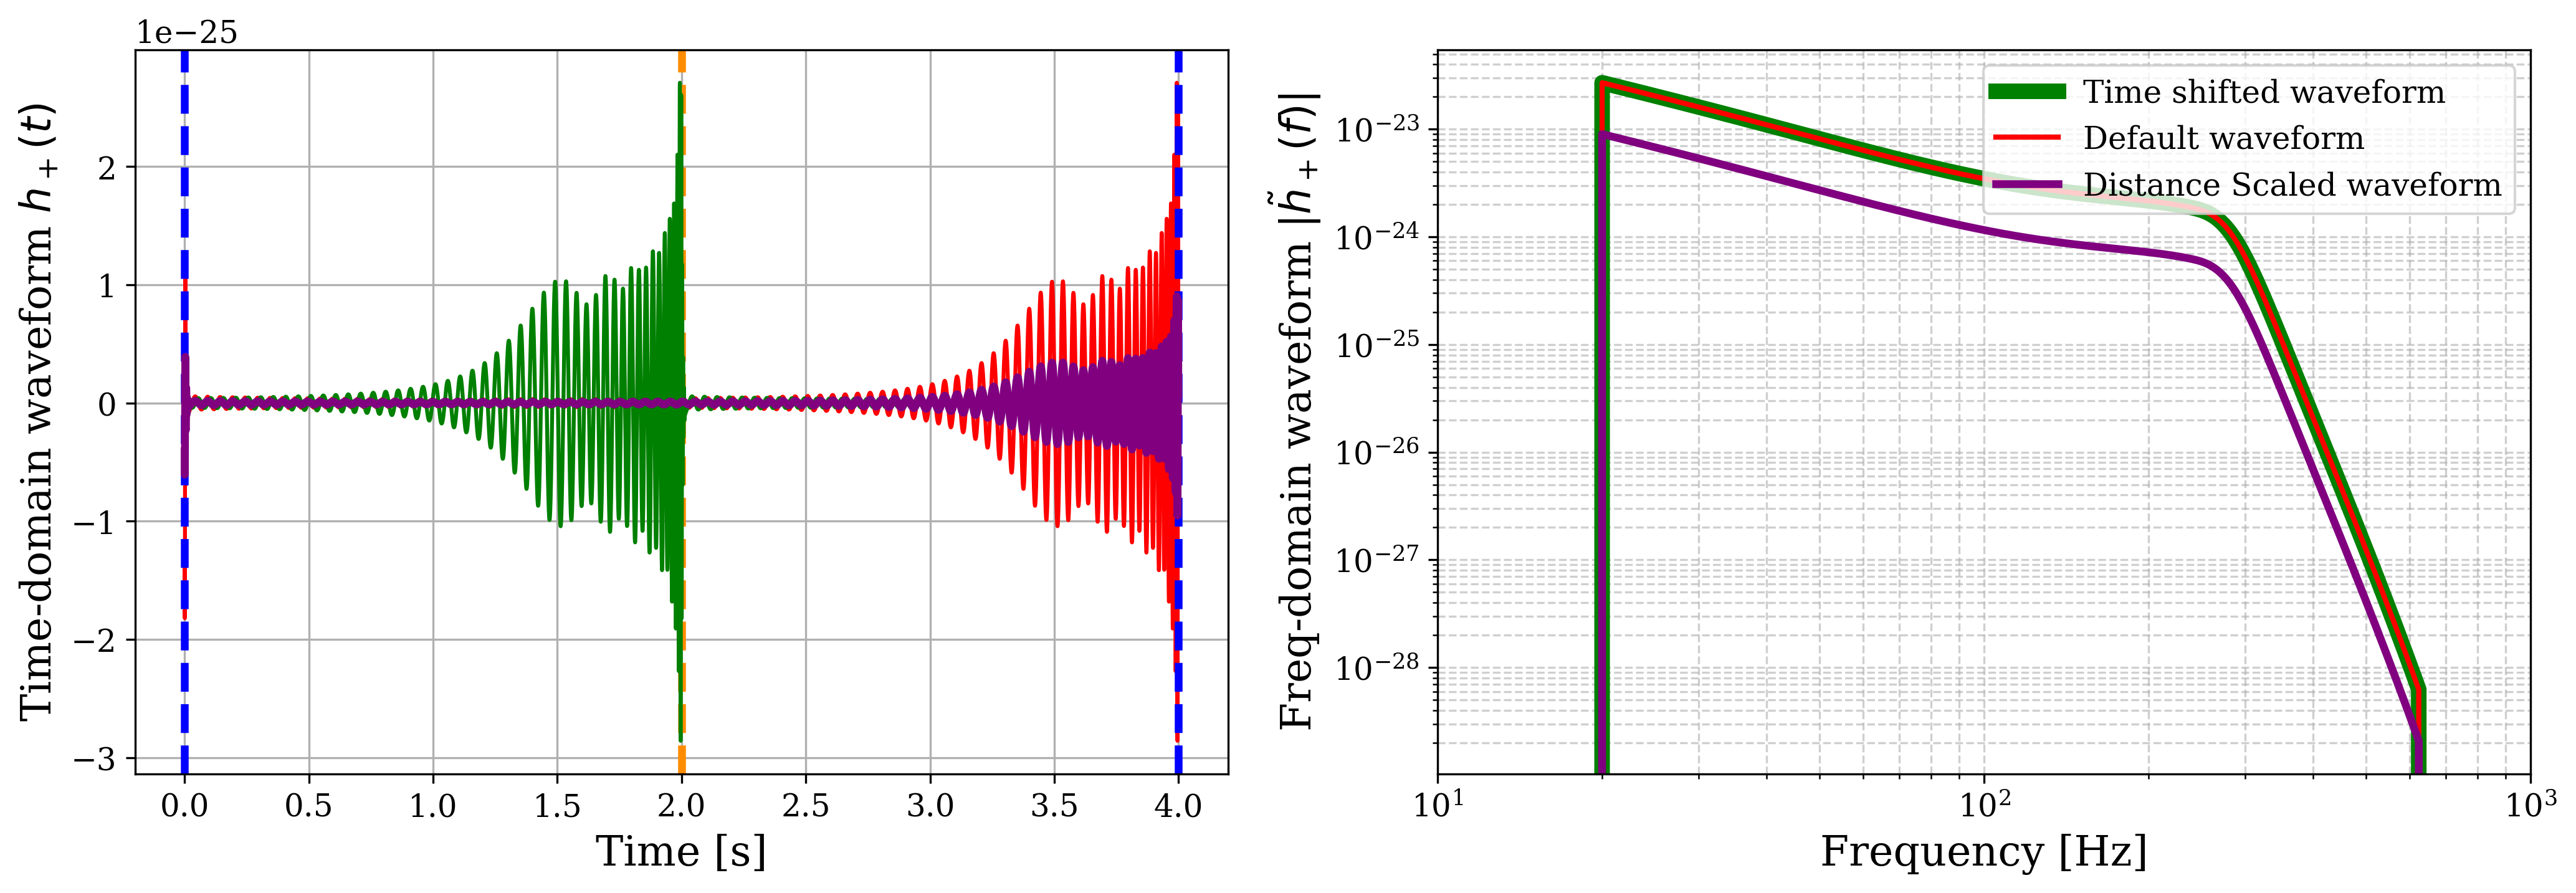

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Tranformation under the a time shift of 2 seconds
h_plus = waveform['plus']
h_plus_shifted = waveform['plus'] * np.exp(-2j * np.pi * f_wave * 2)
# Scaled by 1/Dl - Double the distance to 3 Gpc
h_plus_scaled = waveform['plus'] / 3

# --- Time-domain plot ---
h_plus_time = np.fft.irfft(waveform['plus'])
h_plus_time_shifted = np.fft.irfft(h_plus_shifted)
h_plus_time_scaled = np.fft.irfft(h_plus_scaled)

# Plot the unshifted waveform
axs[0].plot(plot_time, h_plus_time, color='red', label="Default waveform")
axs[0].axvline(plot_time[0], color='blue', linestyle='--', linewidth=3, label="Unshifted Coalescence")
axs[0].axvline(plot_time[-1], color='blue', linestyle='--', linewidth=3)

# Plot the shifted waveform
axs[0].axvline(plot_time[0] + 2, color='darkorange', linestyle='--', linewidth=3, label="Shifted Coalescence")
axs[0].plot(plot_time, h_plus_time_shifted, color='green', label="Shifted waveform")

# Plot the scaled waveform
axs[0].plot(plot_time, h_plus_time_scaled, color='purple', linewidth=3, label="Scaled waveform")

axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Time-domain waveform $h_+(t)$')
axs[0].grid(True)

# --- Frequency-domain plot ---
# Plot the shifted waveform
axs[1].loglog(f_wave, np.abs(h_plus_shifted), color='green', linewidth=6, label="Time shifted waveform")
# Plot the unshifted waveform
axs[1].loglog(f_wave, np.abs(h_plus), color='red', linewidth=2, label="Default waveform")
# Plot the scaled waveform
axs[1].loglog(f_wave, np.abs(h_plus_scaled), color='purple', linewidth=3, label="Distance Scaled waveform")
axs[1].legend(loc ='upper right')


axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel(r'Freq-domain waveform $|\tilde{h}_+(f)|$')
axs[1].set_xlim(10, 1000)
axs[1].grid(True, which='both', ls='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **General Likelihood Function**
- Following the mathematical description above this function implements the log-liklihood in code (unnormalised).

In [4]:
# Creating the overall likelihood function
def single_likelihood(detector, detector_strain, detector_psd, freq_array, waveform, gps_start_time, ra, dec, psi, t_geo, Dl):
    """
    Compute the unnormalised log-likelihood of a gravitational wave signal given a sky location, 
    polarization angle, coalescence time, and luminosity distance for a single detector.

    Parameters
    ----------
    detector : str
        The detector name, must be one of 'H1', 'L1', or 'V1'.
    detector_strain : array-like
        The observed strain data in the frequency domain for the detector.
    detector_psd : array-like
        The one-sided power spectral density (PSD) of the detector.
    delta_f : float
        The frequency resolution of the data (Hz).
    freq_array : array-like
        Array of frequencies corresponding to the Fourier components.
    waveform_h_plus : array-like
        Frequency-domain gravitational wave strain for the plus polarization (at 1 Gpc).
    waveform_h_cross : array-like
        Frequency-domain gravitational wave strain for the cross polarization (at 1 Gpc).
    ra : float
        Right ascension of the source in radians.
    dec : float
        Declination of the source in radians.
    psi : float
        Polarization angle in radians.
    t_geo : float
        Time of coalescence at the geocenter (Not GPS time).
    Dl : float
        Luminosity distance to the source in Gpc.

    Returns
    -------
    log_likelihood : float
        The log-likelihood of the observed data given the signal model at this sky location.
    """

    # Calculate the time delay from the geocenter
    time_delay = detector.time_delay_from_geocenter(ra=ra, dec=dec, time= gps_start_time)

    # Calculate the expected arrival time at the detector - relative to the model time
    shift_time = t_geo + time_delay
    
    # Calculate the antenna response for the given RA, Dec, and Psi
    Fplus = detector.antenna_response(ra, dec, gps_start_time, psi, 'plus')
    Fcross = detector.antenna_response(ra, dec, gps_start_time, psi, 'cross')

    # Calculate the expected strain at the detector - no fourier shift
    # Amplitude is affected by the distance to the source (1Gpc/Dl)
    expected_strain = (Fplus * waveform['plus'] + Fcross * waveform['cross'])/Dl 

    # With a time shift - using fourer transform property
    transformed_expected_strain = expected_strain * np.exp(-2j * np.pi * freq_array * shift_time)

    # The residual strain is the difference between the detector strain and the expected strain
    residual_strain = detector_strain - transformed_expected_strain

    # Determine the frequency resolution
    delta_f = freq_array[1] - freq_array[0]

    # Using a gaussian likelihood model

    log_likelihood = - 2 * delta_f * np.sum(np.real(residual_strain * np.conj(residual_strain) / detector_psd))

    return log_likelihood

## **Build Interferometer Specific Samplers**
- Using the framework above define specifc likelihood functions for each interferometer
- We input the strain psd etc
- We also define the relative times (ie input the GPS start time)

In [5]:
# Intialise the interferometer object for each detector
H1 = bilby.gw.detector.InterferometerList(['H1'])[0]
L1 = bilby.gw.detector.InterferometerList(['L1'])[0]
V1 = bilby.gw.detector.InterferometerList(['V1'])[0]

def H1_likelihood(params):
    """
    Compute the log-likelihood for the H1 detector.

    Parameters
    ----------
    params : list or array-like
        A sequence of the following parameters:
        - ra : float
            Right ascension of the source [radians].
        - dec : float
            Declination of the source [radians].
        - psi : float
            Polarization angle [radians].
        - t_geo : float
            Coalescence time at the geocenter (relative to GPS) [seconds].
        - Dl : float
            Luminosity distance to the source [Gpc].

    Returns
    -------
    log_likelihood : float
        The unnormalized log-likelihood for the given parameters and the H1 detector data.
    """
    ra, dec, psi, t_geo, Dl = params
    return single_likelihood(H1, H1_strain, H1_Sn, H1_f_psd, waveform, gps_start_time, ra, dec, psi, t_geo, Dl)

def L1_likelihood(params):
    """
    Likelihood function for the L1 detector.
    """
    ra, dec, psi, t_geo, Dl = params
    return single_likelihood(L1, L1_strain, L1_Sn, L1_Sn_f, waveform, gps_start_time, ra, dec, psi, t_geo, Dl)

def V1_likelihood(params):
    """
    Likelihood function for the V1 detector.
    """
    ra, dec, psi, t_geo, Dl = params
    return single_likelihood(V1, V1_strain, V1_Sn, LV_Sn_f, waveform, gps_start_time, ra, dec, psi, t_geo, Dl)

## **Create Multi Object Detectors**
$$
\{d_i\}_{\mathcal{I}=1}^{N_{\text{det}}}:\quad
\log \mathcal{L}(\{d_i\} \mid \vec{\theta}) 
\propto 
\sum_{\mathcal{I}=1}^{N_{\text{det}}} \mathcal{L}(d_\mathcal{I} \mid \vec{\theta}) 
$$



In [6]:
# Combined likelihood functions for multiple detectors
# H1 and L1 combined likelihood function
def H1_L1_likelihood(params):
    """
    Combined likelihood function for H1 and L1 detectors.
    """
    return H1_likelihood(params) + L1_likelihood(params)


# H1, L1 and V1 combined likelihood function
def H1_L1_V1_likelihood(params):
    """
    Combined likelihood function for all detectors.
    """
    return H1_likelihood(params) + L1_likelihood(params) + V1_likelihood(params)

## **Dynesty Nested Sampling**

### **Implementing Choices of Priors**

In `dynesty`'s nested sampling, we define *hypercube prior transforms* for each of our parameters. These transforms map samples drawn from the unit cube \([0, 1]^N\) into the corresponding physical parameter space.

We use the following priors in our analysis:

| Parameter         | Prior Description                                  |
|------------------|-----------------------------------------------------|
| **RA**            | Uniform over $[0, 2\pi]$                         |
| **Dec**           | Uniform in solid angle: $\sin(\text{Dec}) \in [-1, 1]$ |
| **$\psi$**      | Uniform over $[0, \pi]$                          |
| **$t_{\text{geo, relative}}$** | Uniform over $[0, 4]$ seconds              |
| **$D_l$**        | Log-uniform over $[10^{-2}, 100]$ Gpc (i.e. 10 Mpc to 100 Gpc) |

In [7]:
# Defining the unit cube prior transform function
def prior_transform(unit_cube):
    """
    Maps a unit cube sample from the nested sampler to the physical parameter space 
    of the Gravitational Wave bayesian analysis.

    This function defines the transformation from the unit hypercube (where all parameters 
    are sampled uniformly in [0, 1]) into the parameter space of the gravitational wave model.
    Each parameter is transformed according to its prior distribution:

    - Right Ascension (RA): Uniform on [0, 2pi] radians.
    - Declination (Dec): Sine-uniform on [-pi/2, pi/2] radians This is to ensure uniform distribution on the sphere.
    - Polarization angle (ψ): Uniform on [0, pi] radians
    - Time of coalescence (t_geo_relative): Uniform in [0, 4] seconds relative to a fixed GPS start time.
    - Luminosity distance (D_L): Log-uniform in [0.01, 100] Gpc. Jefferies prior as we are unsure about the distribution distance.

    Parameters
    ----------
    unit_cube : ndarray
        1D array of samples drawn uniformly from [0, 1] for each parameter.
        Expected length: 5, corresponding to [u_ra, u_dec, u_psi, u_t, u_dl].

    Returns
    -------
    params : ndarray
        Array of physical parameter values [ra, dec, psi, t_geo_relative, Dl] after transformation.
    """
    # Unwrap the unit cube values - simple samples [0,1] for each parameter
    u_ra, u_dec, u_psi, u_t, u_dl = unit_cube

    # convert ra to Uniform in [0, 2pi]
    ra = 2 * np.pi * u_ra 
    # convert dec to sin-uniform in [-pi/2, pi/2]
    dec = np.arcsin(2 * u_dec - 1)
    # convert psi to Uniform in [0, pi]
    psi = np.pi * u_psi 
    # convert t_geo_relative to Uniform in [0, 4] seconds this is then added to the gps_start_time in the likelihood functions
    t_geo_relative = 4 * u_t 
    # convert Dl to log-uniform in [0.01, 100] Gpc
    Dl = 10 ** (-2 + 4 * u_dl)

    return np.array([ra, dec, psi, t_geo_relative, Dl])

## **Intialise the Dynesty Samplers and Running them:**
## **Optimise the Sampler**
- Before running a complete nested sampling run, we investiagte the use of Dynesty Nested Sampler Options.
    - We run over all permutations of the options.
    - For this we only use 500 live points and compare efficiency rate and total run time of convergence.


### **Parameter Options**

#### **Bound**

| Bound Type | Description |
|------------|-------------|
| `single` | A single ellipsoidal is used to bound to enclose all live points. Assuming the posterior follows a similiar distribution this could be the fastest.|
| `multi` | Uses multiple ellipsoidal is used to bound to enclose all live points. More flexible but computationally expensive. |
| `balls` | Uses a collection of spheres(hyper). |

### **Sample** 

| Bound Type | Description |
|------------|-------------|
| `rwalk` | Uses a ranfom walk from current live points. |
| `slice` | Slice sampling within the bounded region. |
| `rslope` | Uses random slice sampling along all orientations|


In [8]:
if rerun_optimisation:
    bound_options = ['single', 'multi', 'balls']
    sample_options = ['rwalk', 'slice', 'rslice']
    optimisation_results = {}

    for i in range(len(bound_options)*len(sample_options)):
        # Select the bound and sample options based on the loop index
        bound = bound_options[i % len(bound_options)]
        sample = sample_options[i // len(bound_options)]
        # Print the current bound and sample options
        print(f"Running with bound='{bound}' and sample='{sample}'")

        # Define the nested sampler with the selected bound and sample options
        sampler = NestedSampler(
            loglikelihood=H1_L1_V1_likelihood,
            prior_transform=prior_transform,
            ndim=5,
            bound=bound,
            sample=sample,
            nlive=500,
            rstate=np.random.default_rng(seed_value),
        )

        # Measure Run Time and Extract Efficiency and save these results
        start_time = time.time()
        sampler.run_nested(dlogz=0.1, print_progress=True)
        end_time = time.time()
        run_time = end_time - start_time
        results = sampler.results
        efficiency = results.eff

        # Store the results in a dictionary
        optimisation_results[(bound, sample)] = {
            'run_time': run_time,
            'efficiency': efficiency,
        }
    
    # Save the results 
    optimisation_results_df = pd.DataFrame([
    {"Bound": bound, "Sample": sample, "Runtime (s)": result["run_time"], "Efficiency": result["efficiency"]}
    for (bound, sample), result in optimisation_results.items()])
    optimisation_results_df.to_csv("results/optimisation/dynesty_optimisation_summary.csv", index=False)
else:
    # Load the results from the file
    optimisation_results_df = pd.read_csv("results/optimisation/dynesty_optimisation_summary.csv")

# Print the results
print("Dynesty Optimisation Summary (ordered by efficiency):\n")
df_results = optimisation_results_df.sort_values(by="Efficiency", ascending=False).reset_index(drop=True)
display(df_results)

Dynesty Optimisation Summary (ordered by efficiency):



Bound  Sample  Runtime (s)  Efficiency
0   multi   rwalk   124.094088    4.400667
1  single   rwalk   120.112610    4.400133
2   balls   rwalk   154.150311    4.337039
3   multi  rslice   215.926747    2.402579
4   balls  rslice   213.031598    2.397458
5  single  rslice   237.280418    2.336697
6  single   slice   423.452082    1.253877
7   multi   slice   444.786329    1.228161

### **Best efficiency:**
- This is achieved with the **'multi' bound** and **'rwalk' sampling** method.
- That being said the **'single' bound** and **'rwalk' sampling** method achieves worse efficiency but slightly better run time (the difference are marginal).



### **Sampling the H1 and L1 Posterior**
- We choose to use **'multi' bound** and **'rwalk' sampling** method.
- We now use `3000 live points` and a `dlogZ == 0.01`


In [9]:
# Set dynesty parameters
ndim = 5  # Number of parameters
nlive = 3000  # Number of live points for dynesty

In [10]:
rerun_sampling = False

In [11]:
if rerun_sampling:
    # Create the Dynesty nested sampler for H1 and L1 detectors
    sampler_H1_L1 = NestedSampler(
        H1_L1_likelihood,
        prior_transform,              
        ndim,                          
        nlive=nlive,                   
        bound='multi',                 
        sample='rwalk',   
        periodic=[0,2],  
        rstate=np.random.default_rng(seed_value),         
    )

    # Run the nested sampling for H1 and L1 detectors
    sampler_H1_L1.run_nested(dlogz=0.01, print_progress=True)
    # Save the results to a file
    sampler_H1_L1.save("results/NS_H1_L1_NLive_3000.save")
else:
    # Load the results from the saved file
    sampler_H1_L1 = NestedSampler.restore("results/NS_H1_L1_NLive_3000.save")

### **Sampling the H1, L1 and V1 Posterior**
- We now use `3000 live points` and a `dlogZ == 0.01`

In [12]:
if rerun_sampling:
    # Create the Dynesty nested sampler for H1, L1 and V1 detectors
    sampler_H1_L1_V1 = NestedSampler(
        H1_L1_V1_likelihood,
        prior_transform,
        ndim,
        nlive=nlive,
        bound='multi',
        sample='rwalk',
        periodic=[0,2],  
        rstate=np.random.default_rng(seed_value),  
    )

    # Run the nested sampling for H1 and L1 detectors
    sampler_H1_L1_V1.run_nested(dlogz=0.01, print_progress=True)
    # Save the results
    sampler_H1_L1_V1.save("results/NS_H1_L1_V1_NLive_3000.save")
else:
    # Load the results from the saved file
    sampler_H1_L1_V1 = NestedSampler.restore("results/NS_H1_L1_V1_NLive_3000.save")

## **Results for H1 and L1**

In [13]:
results_H1_L1 = sampler_H1_L1.results

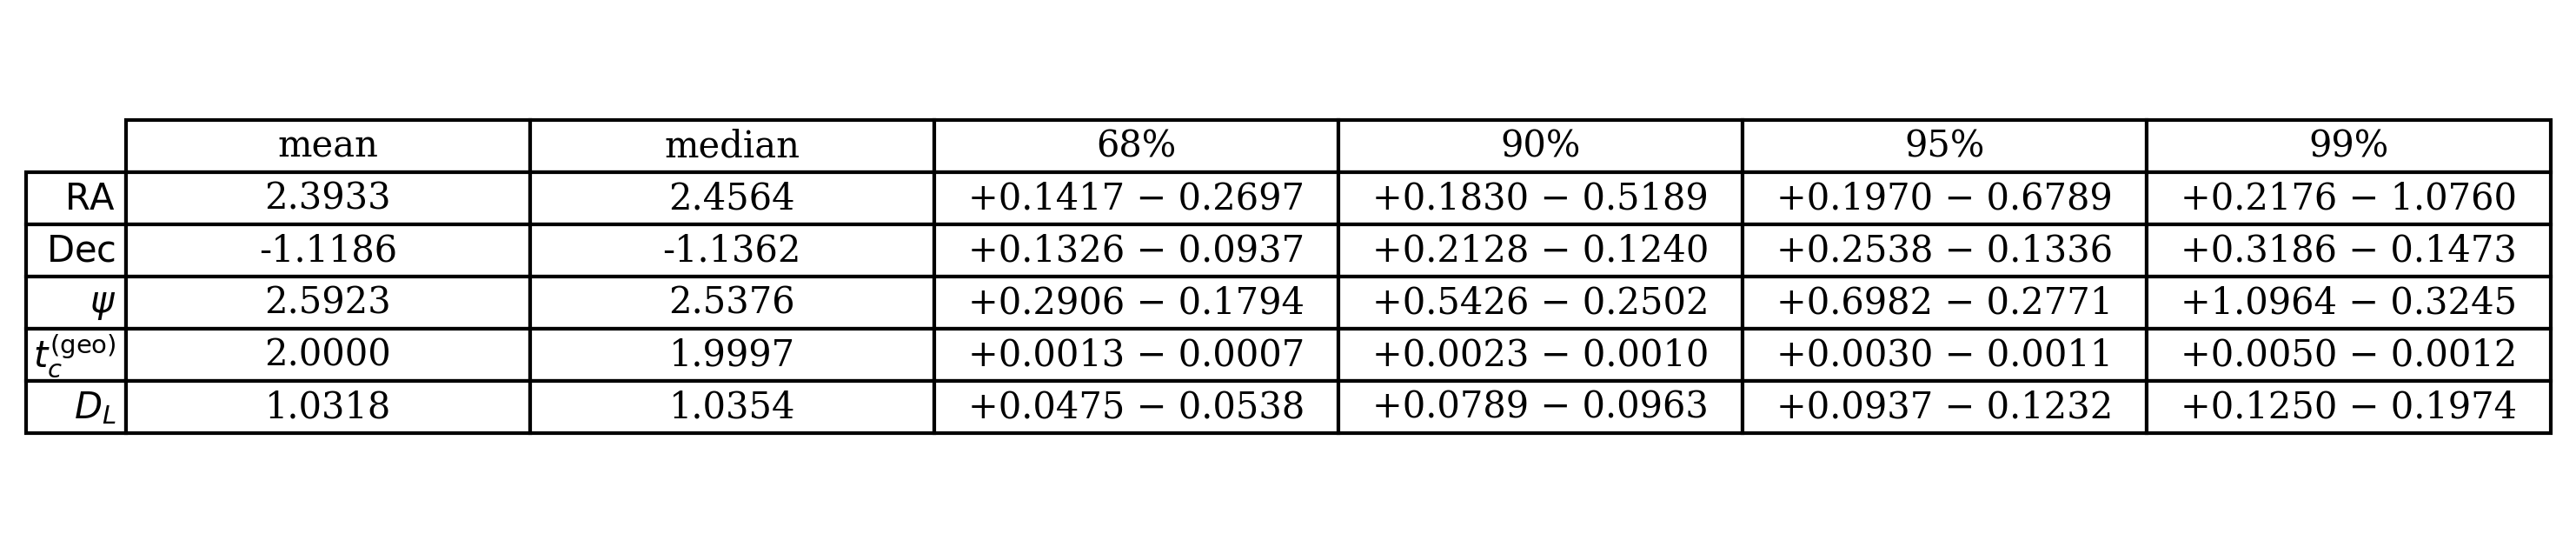

In [14]:
table_dynesty_posteriors(results_H1_L1, shift_psi=True)

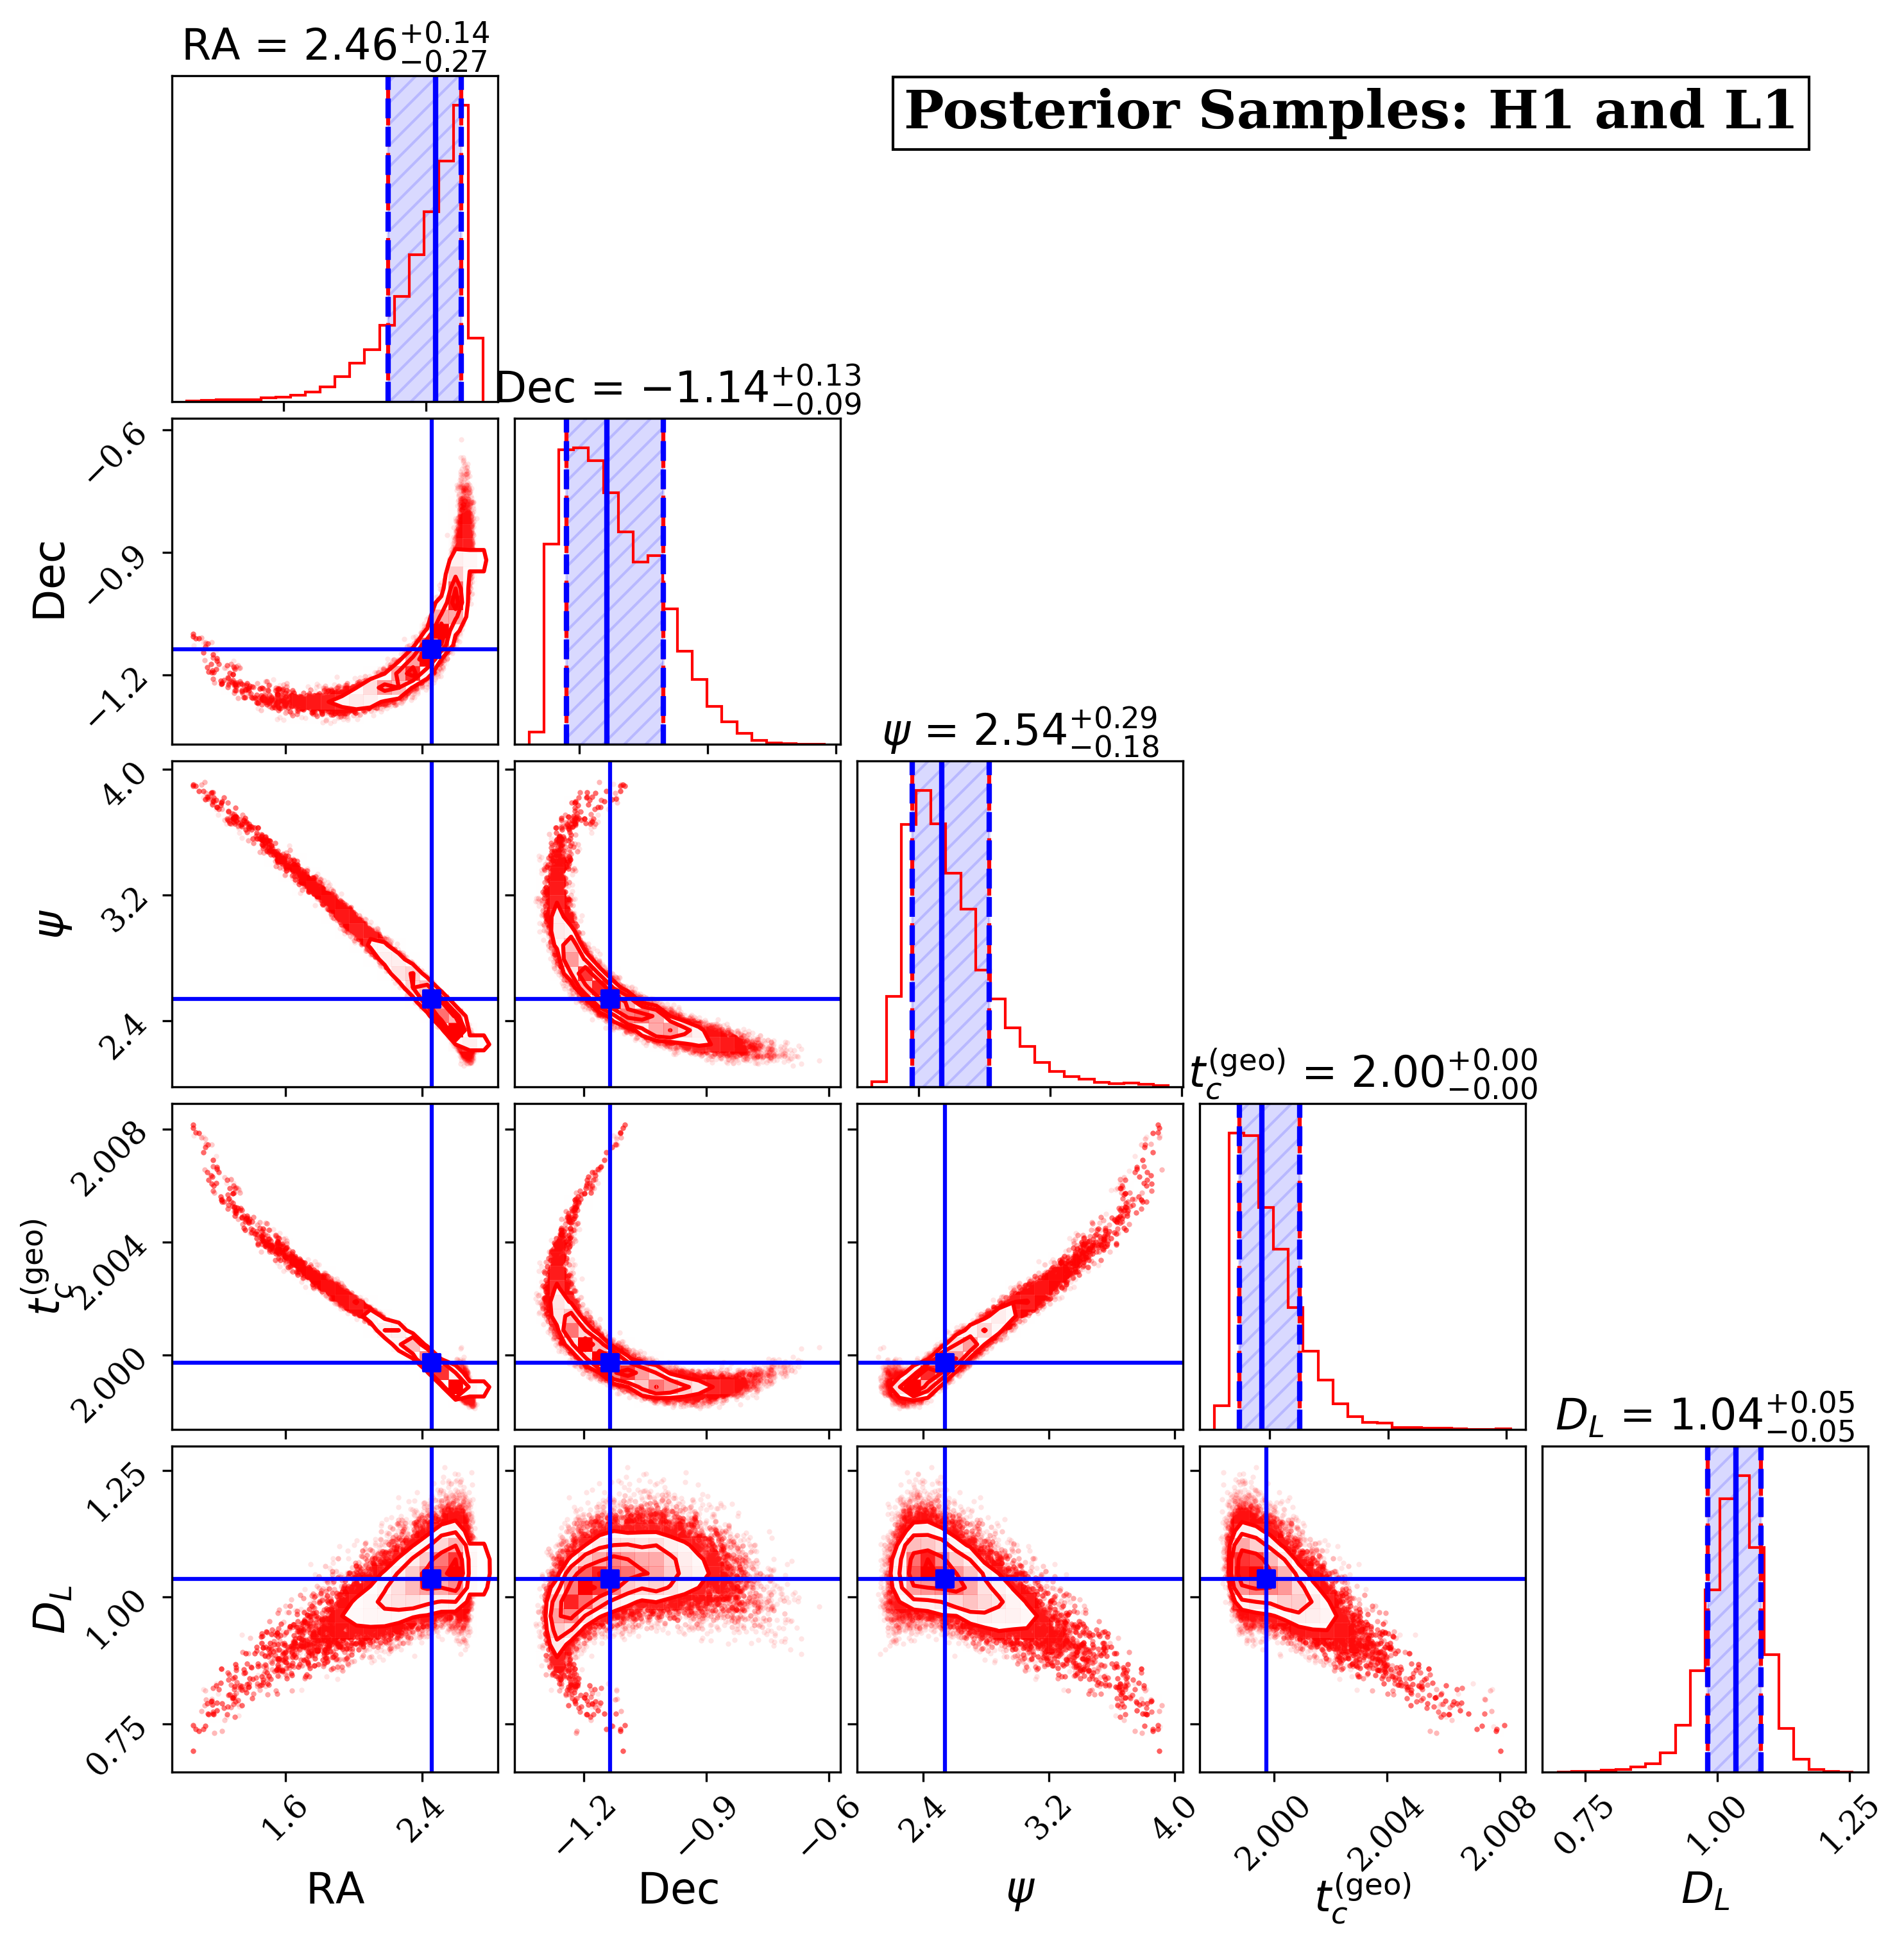

In [15]:
plot_corner_dynesty(results_H1_L1, shift_psi=True)

/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


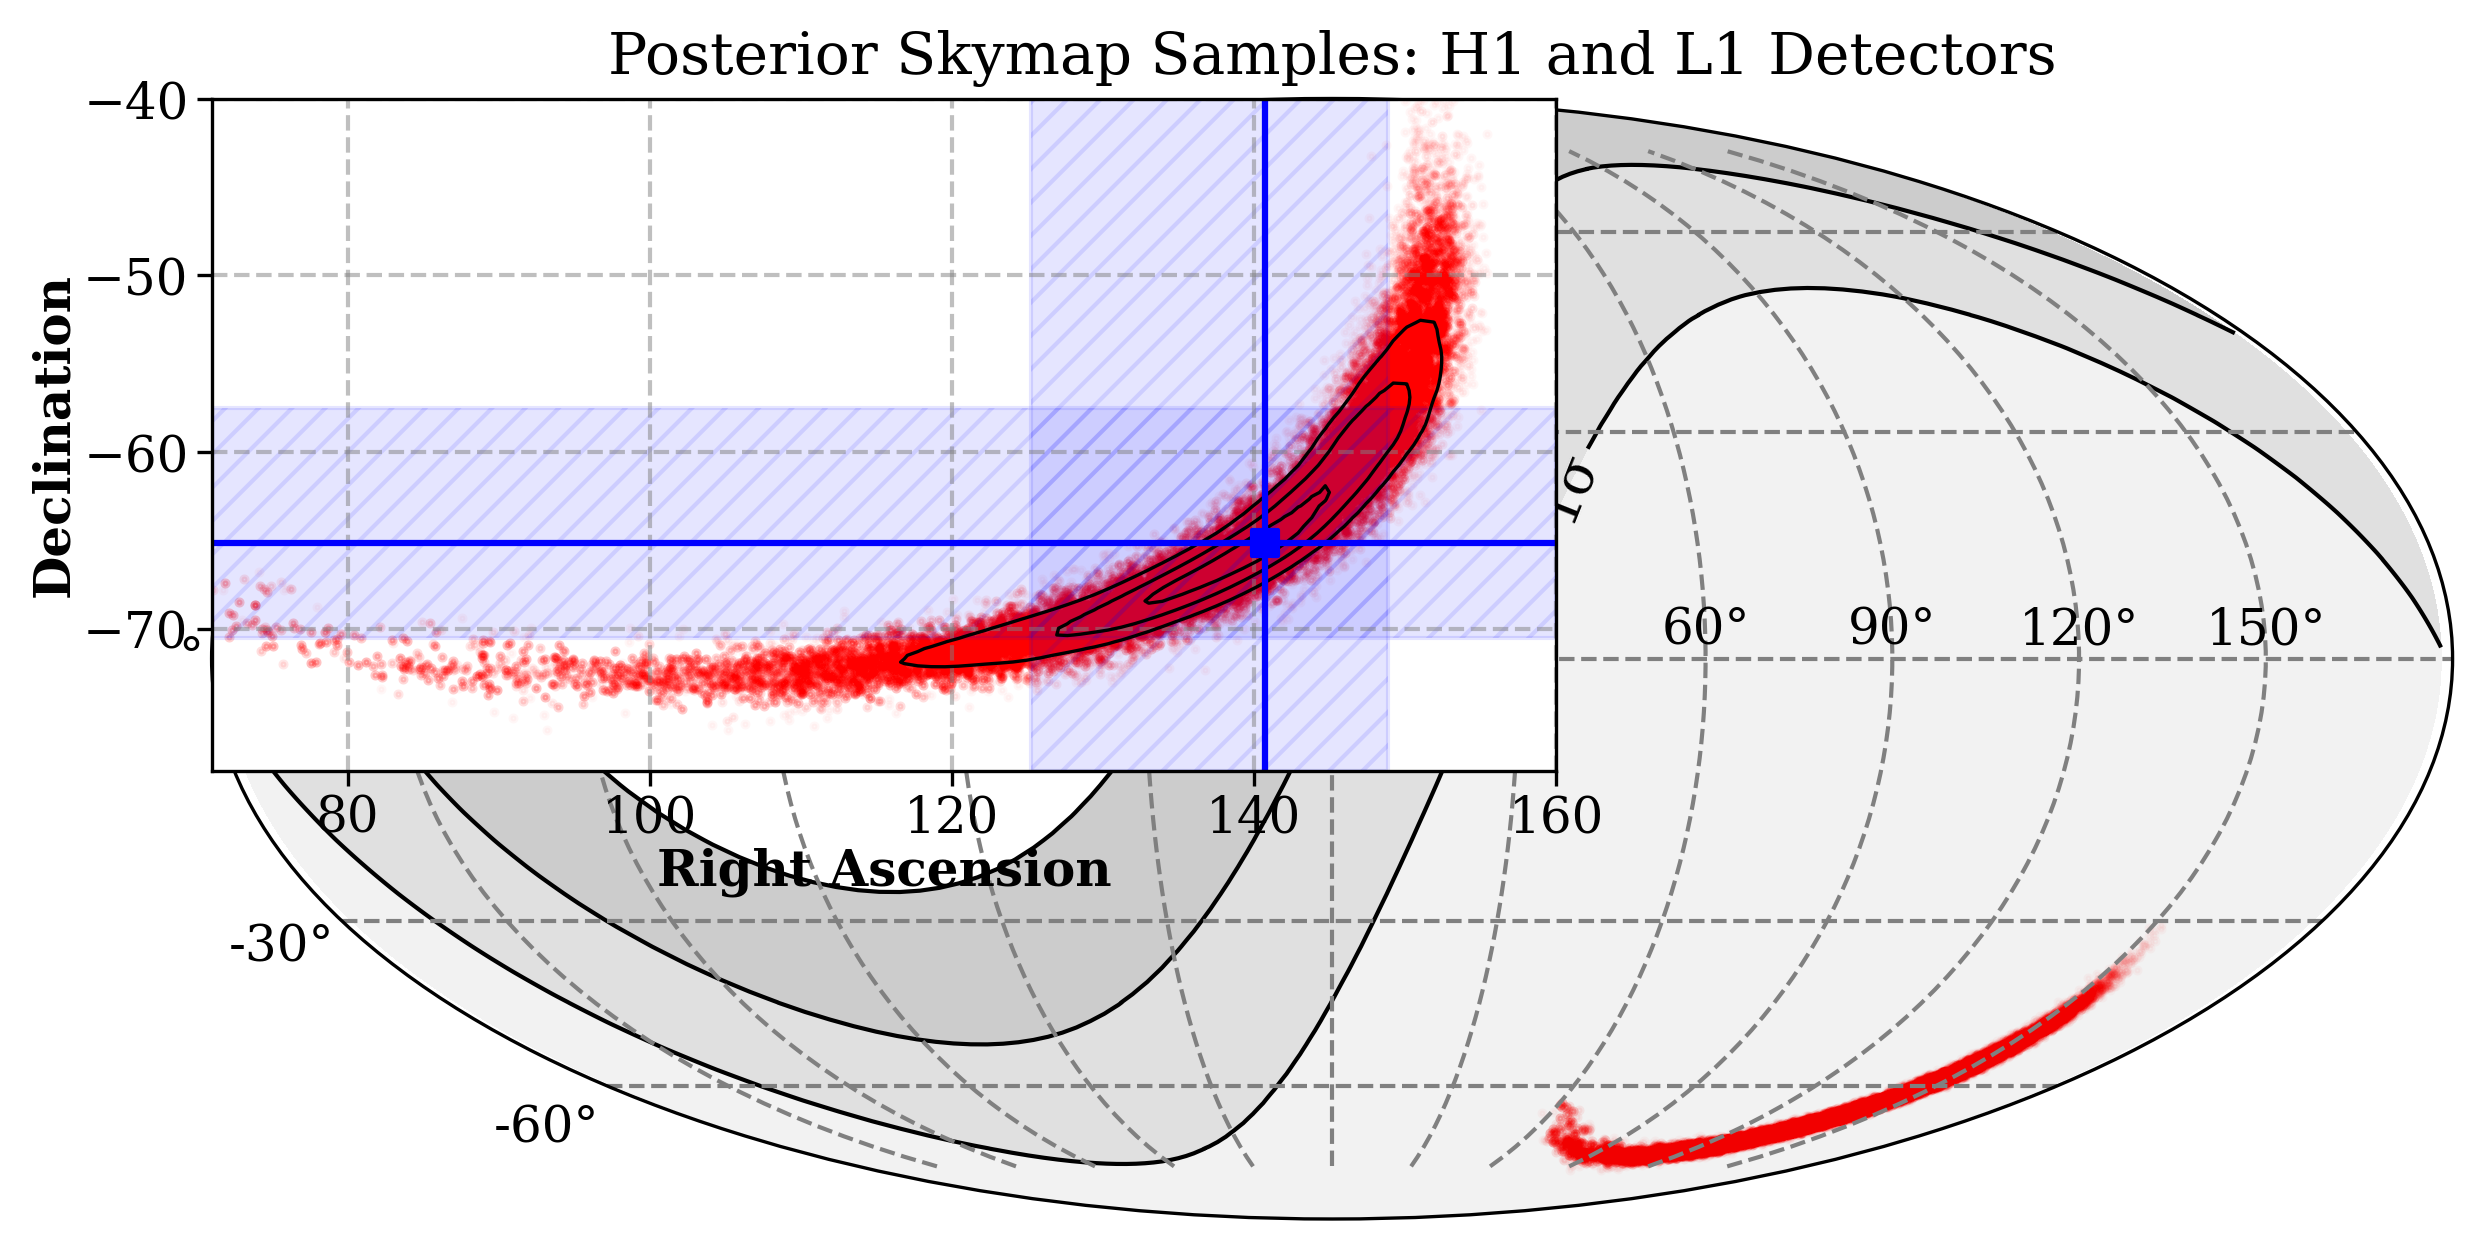

In [16]:
plot_posterior_skymap_samples(results_H1_L1, ra_range = [71,160], dec_range=[-78, -40], title='Posterior Skymap Samples: H1 and L1 Detectors', background='results/H1_L1_prob_map.npy')

## **Results for H1, L1 and V1**

In [17]:
results_H1_L1_V1 = sampler_H1_L1_V1.results

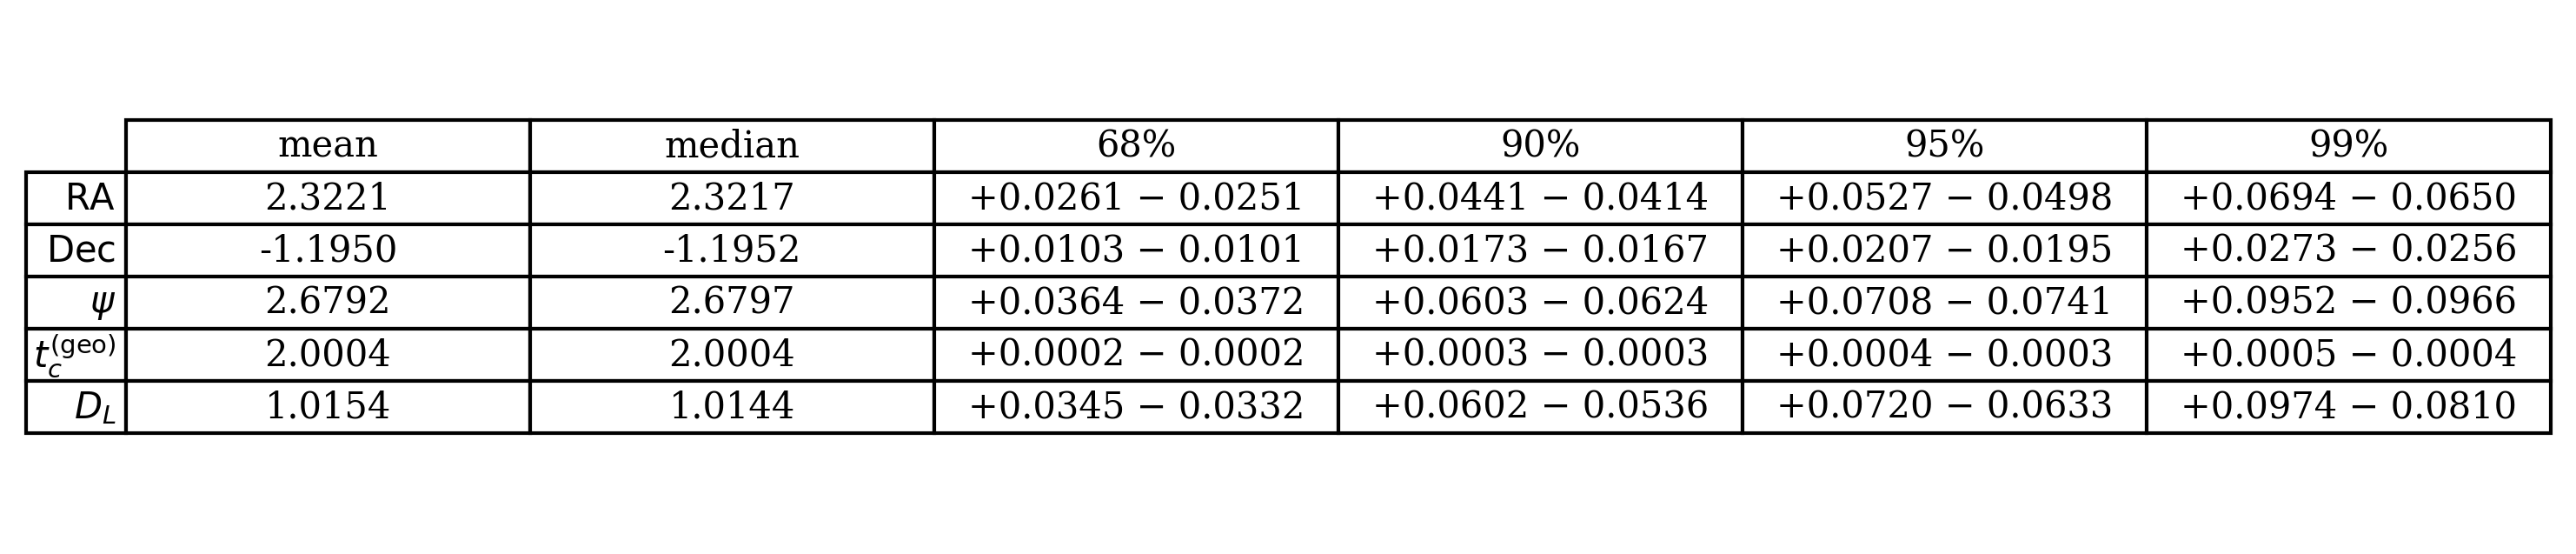

In [18]:
table_dynesty_posteriors(results_H1_L1_V1)

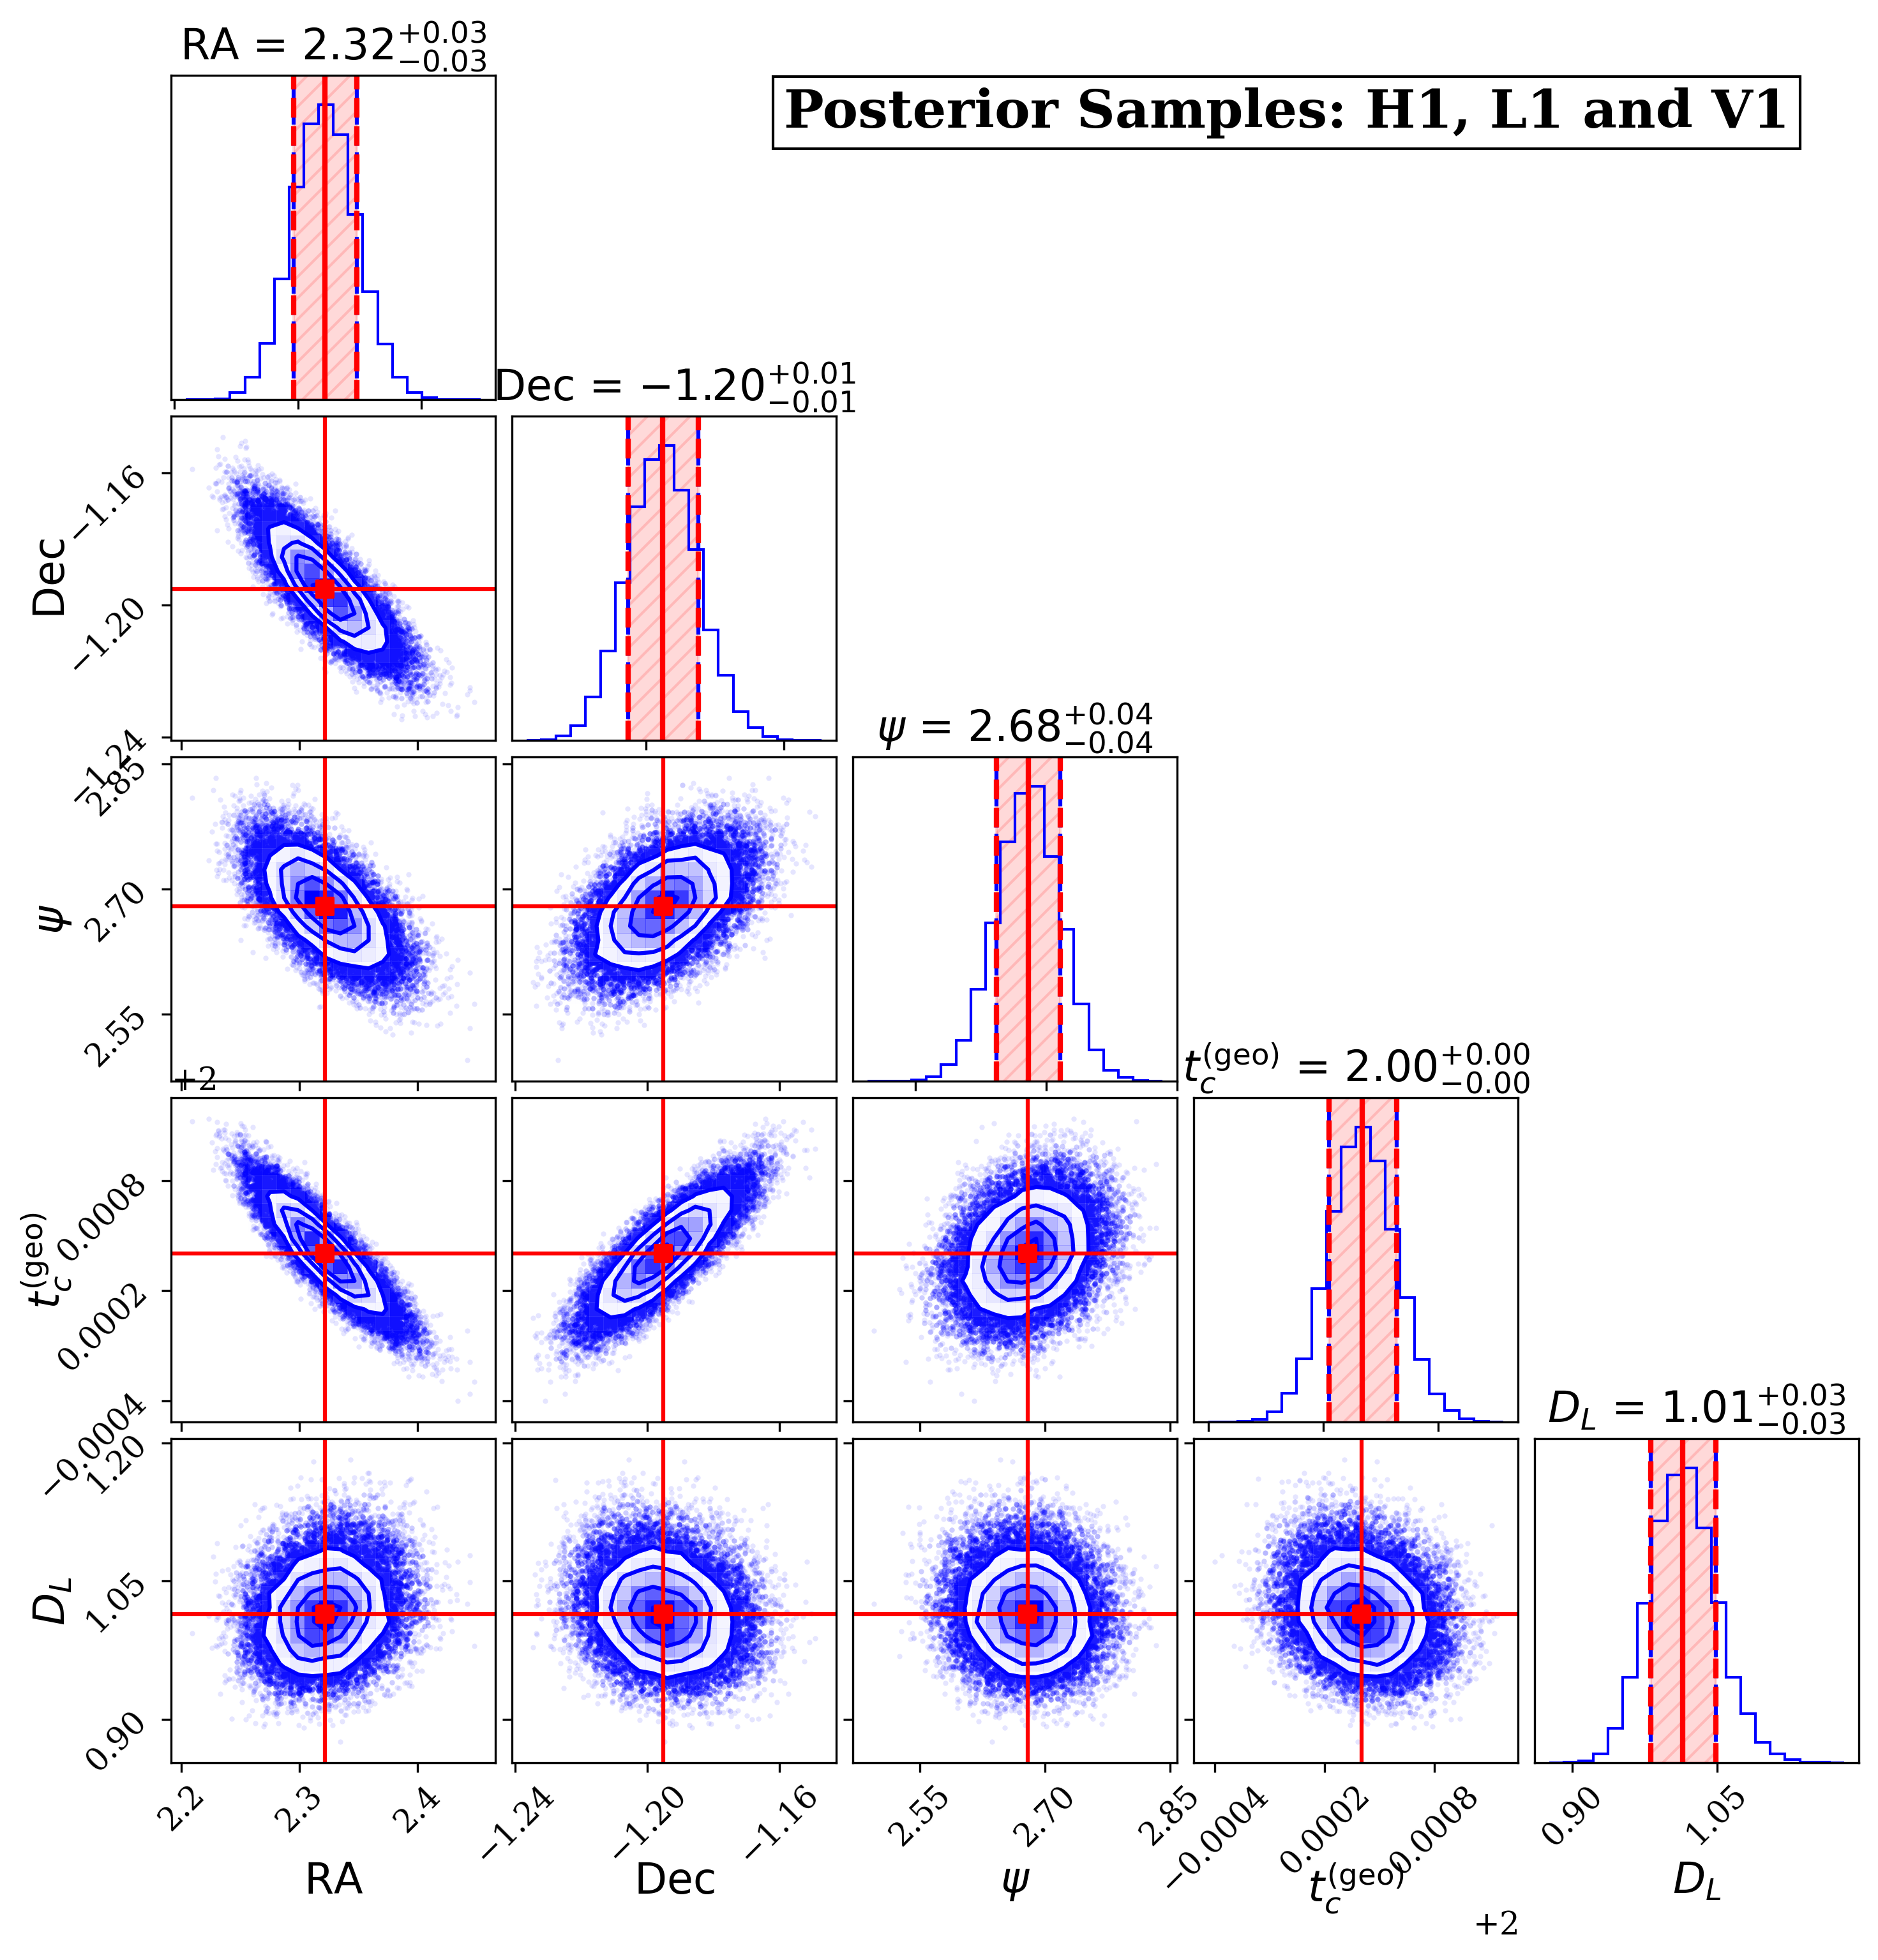

In [19]:
plot_corner_dynesty(results_H1_L1_V1, title='Posterior Samples: H1, L1 and V1', colors=['blue', 'red'], shift_psi=True)

/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


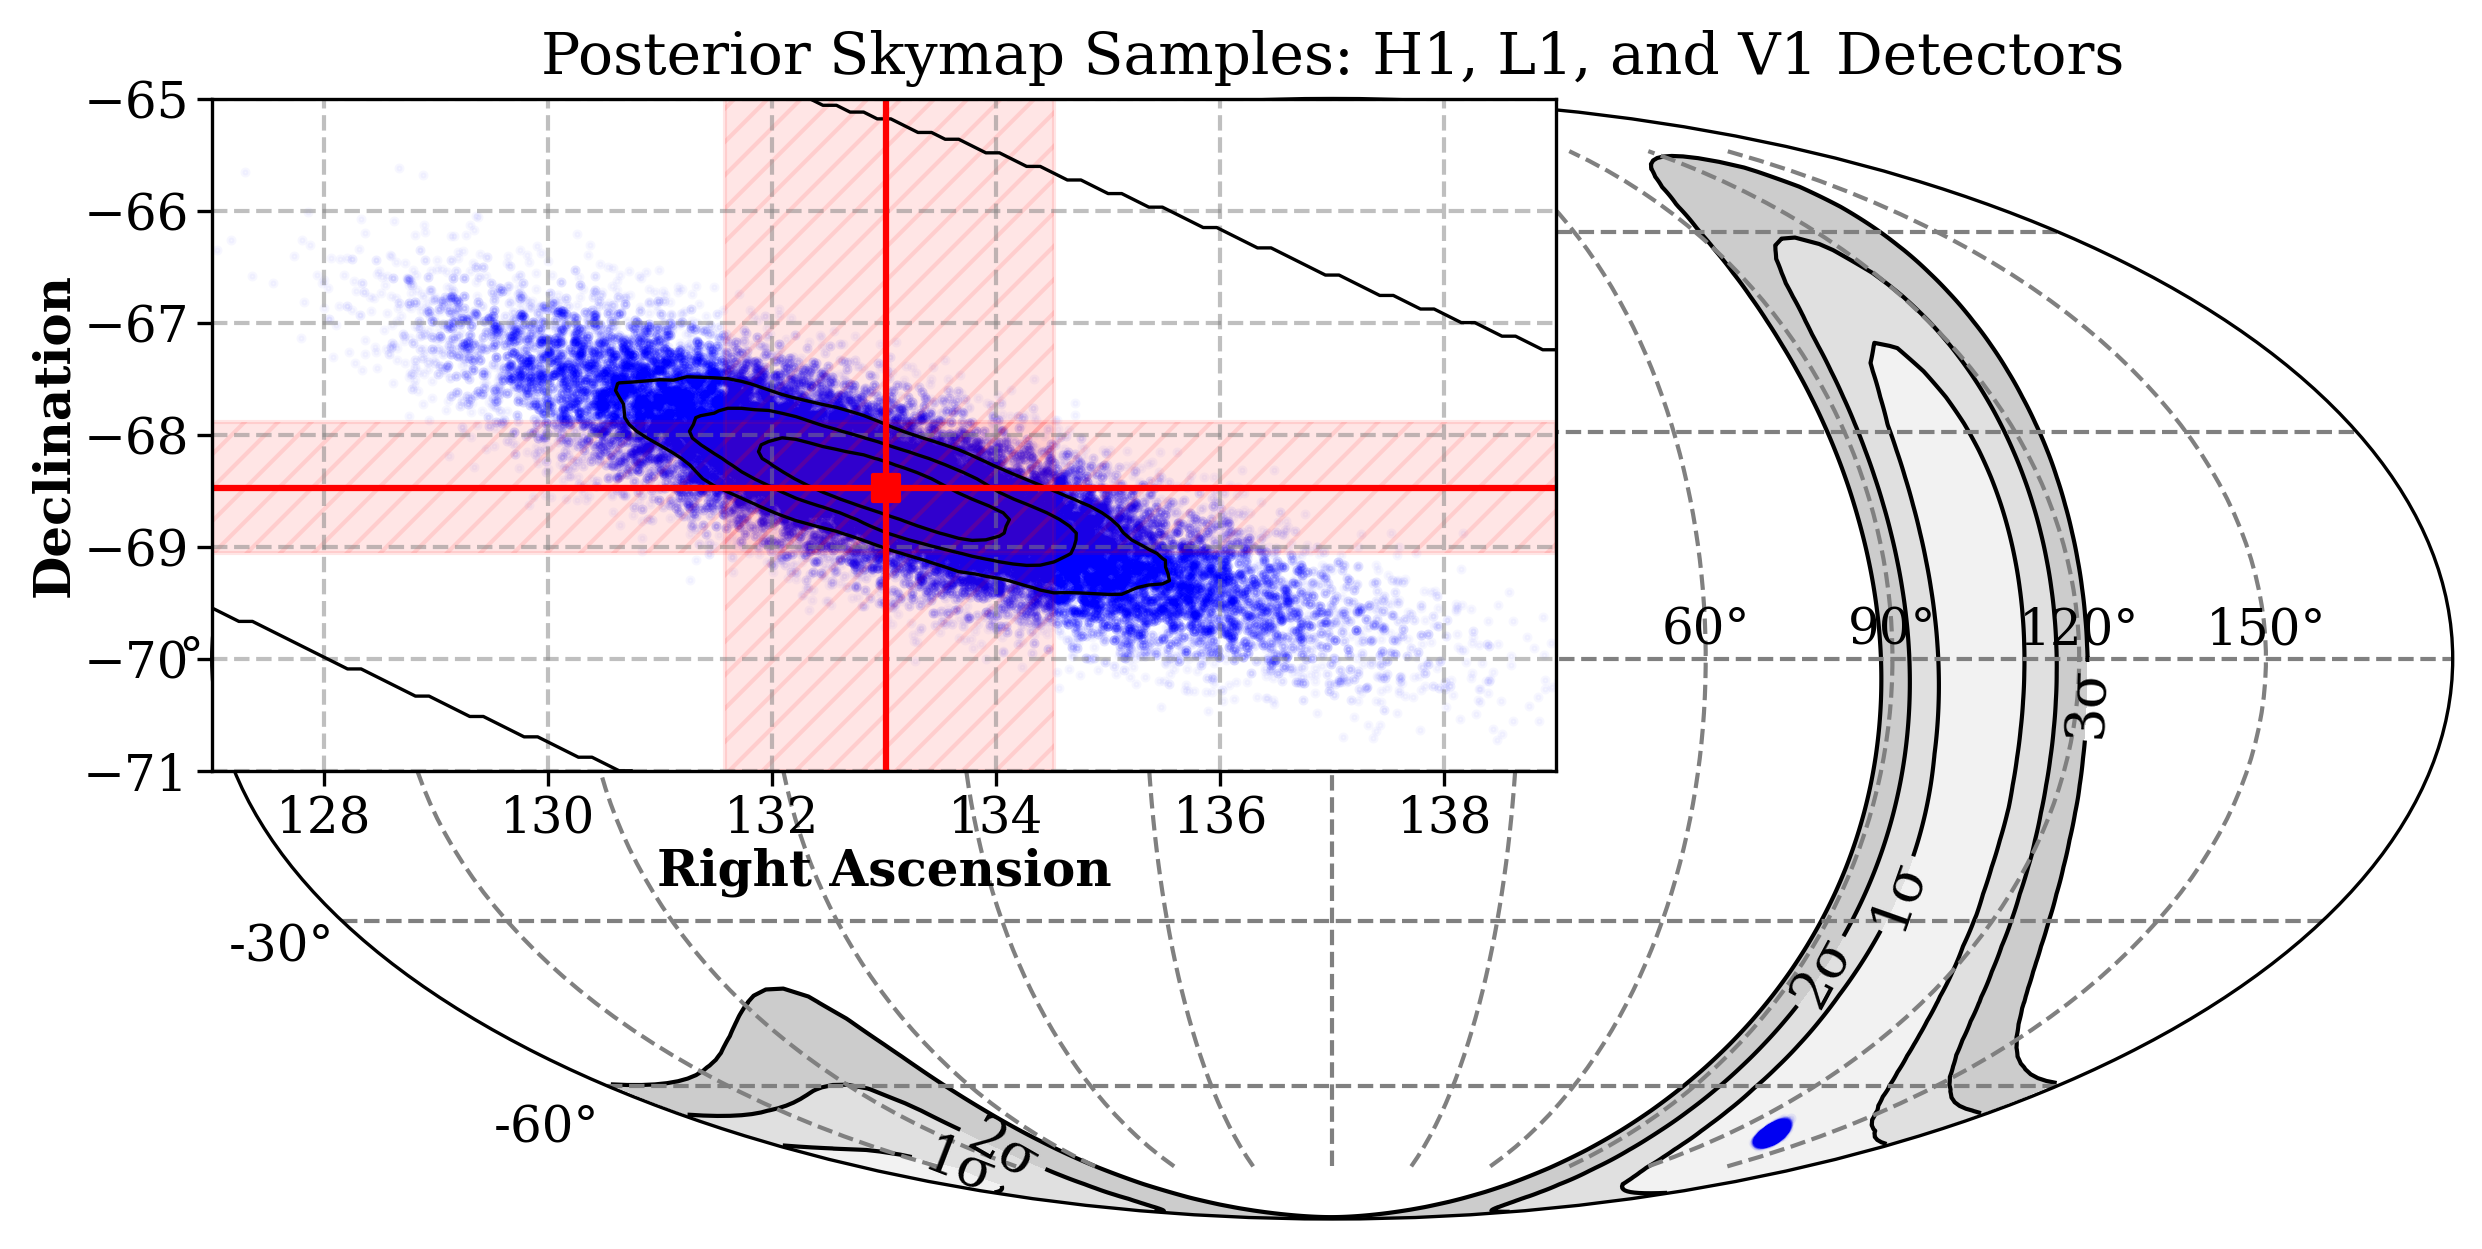

In [20]:
plot_posterior_skymap_samples(results_H1_L1_V1, ra_range= [127,139], dec_range=[-71, -65], title='Posterior Skymap Samples: H1, L1, and V1 Detectors', colors=['blue', 'red'], background='results/H1_L1_V1_prob_map.npy')

## **A Comparison of Parameter Distributions**

## **RA and DEC**

/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:417: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_marg_x.axvspan(lower_ra_bound, upper_ra_bound, color=color, alpha=0.06, hatch='///', edgecolor=color)
/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:418: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_marg_y.axhspan(lower_dec_bound, upper_dec_bound, color=color, alpha=0.06, hatch='///', edgecolor=color)


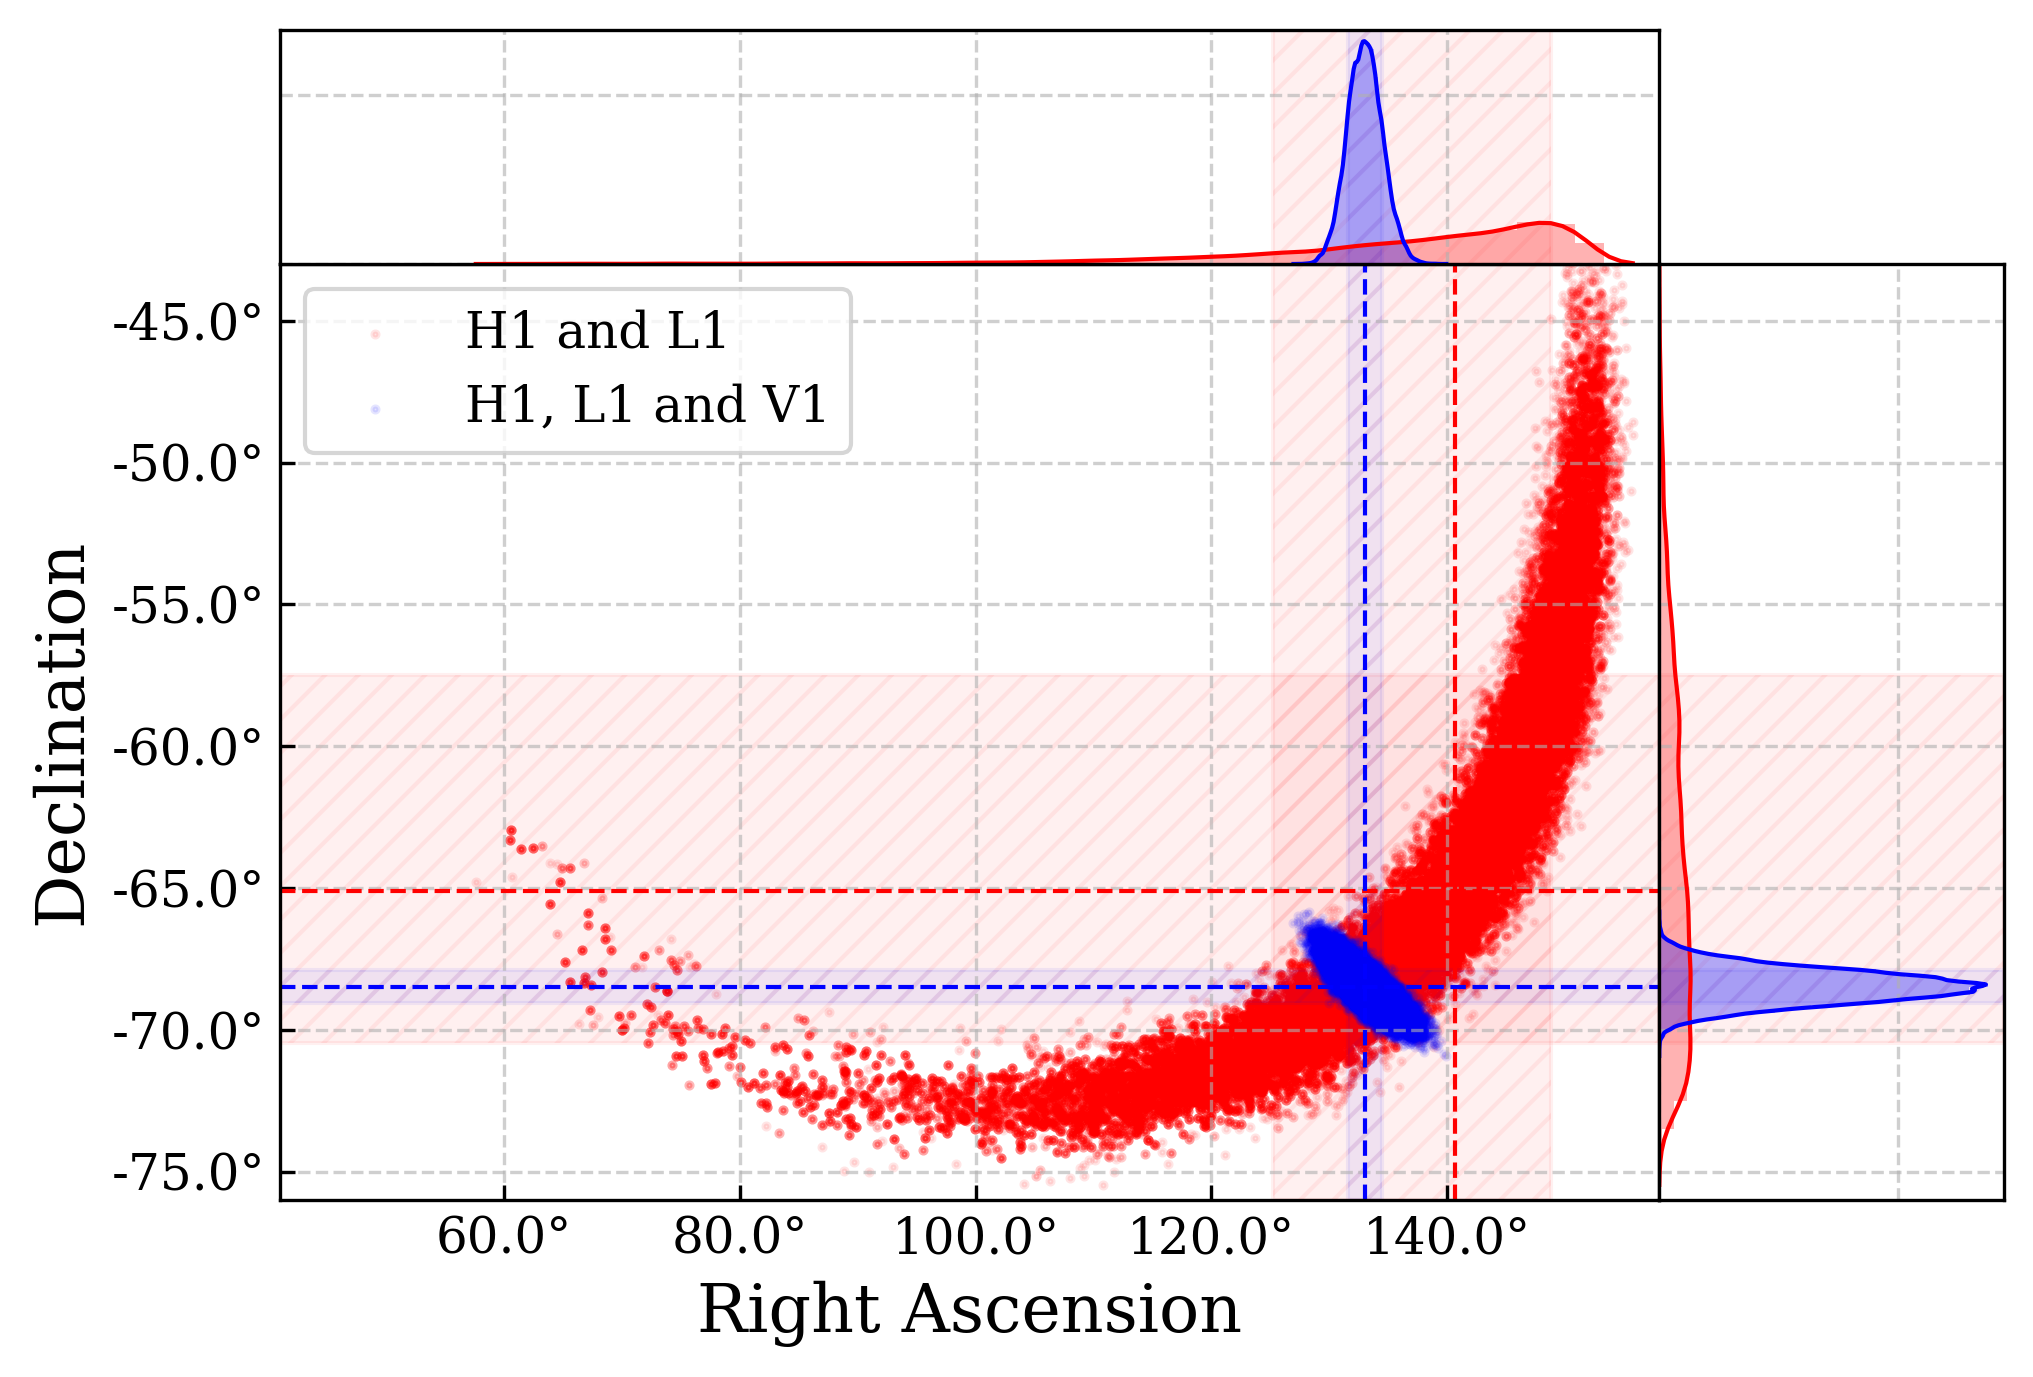

In [21]:
compare_ra_dec(results_H1_L1, results_H1_L1_V1, colors=['red', 'blue'], labels =['H1 and L1', 'H1, L1 and V1'], dec_range=[-76, -43], ra_range=[41, 158])

## **Luminosity Distance**

/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:517: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(lower, upper, color=color, alpha=0.08, hatch='///', edgecolor=color)


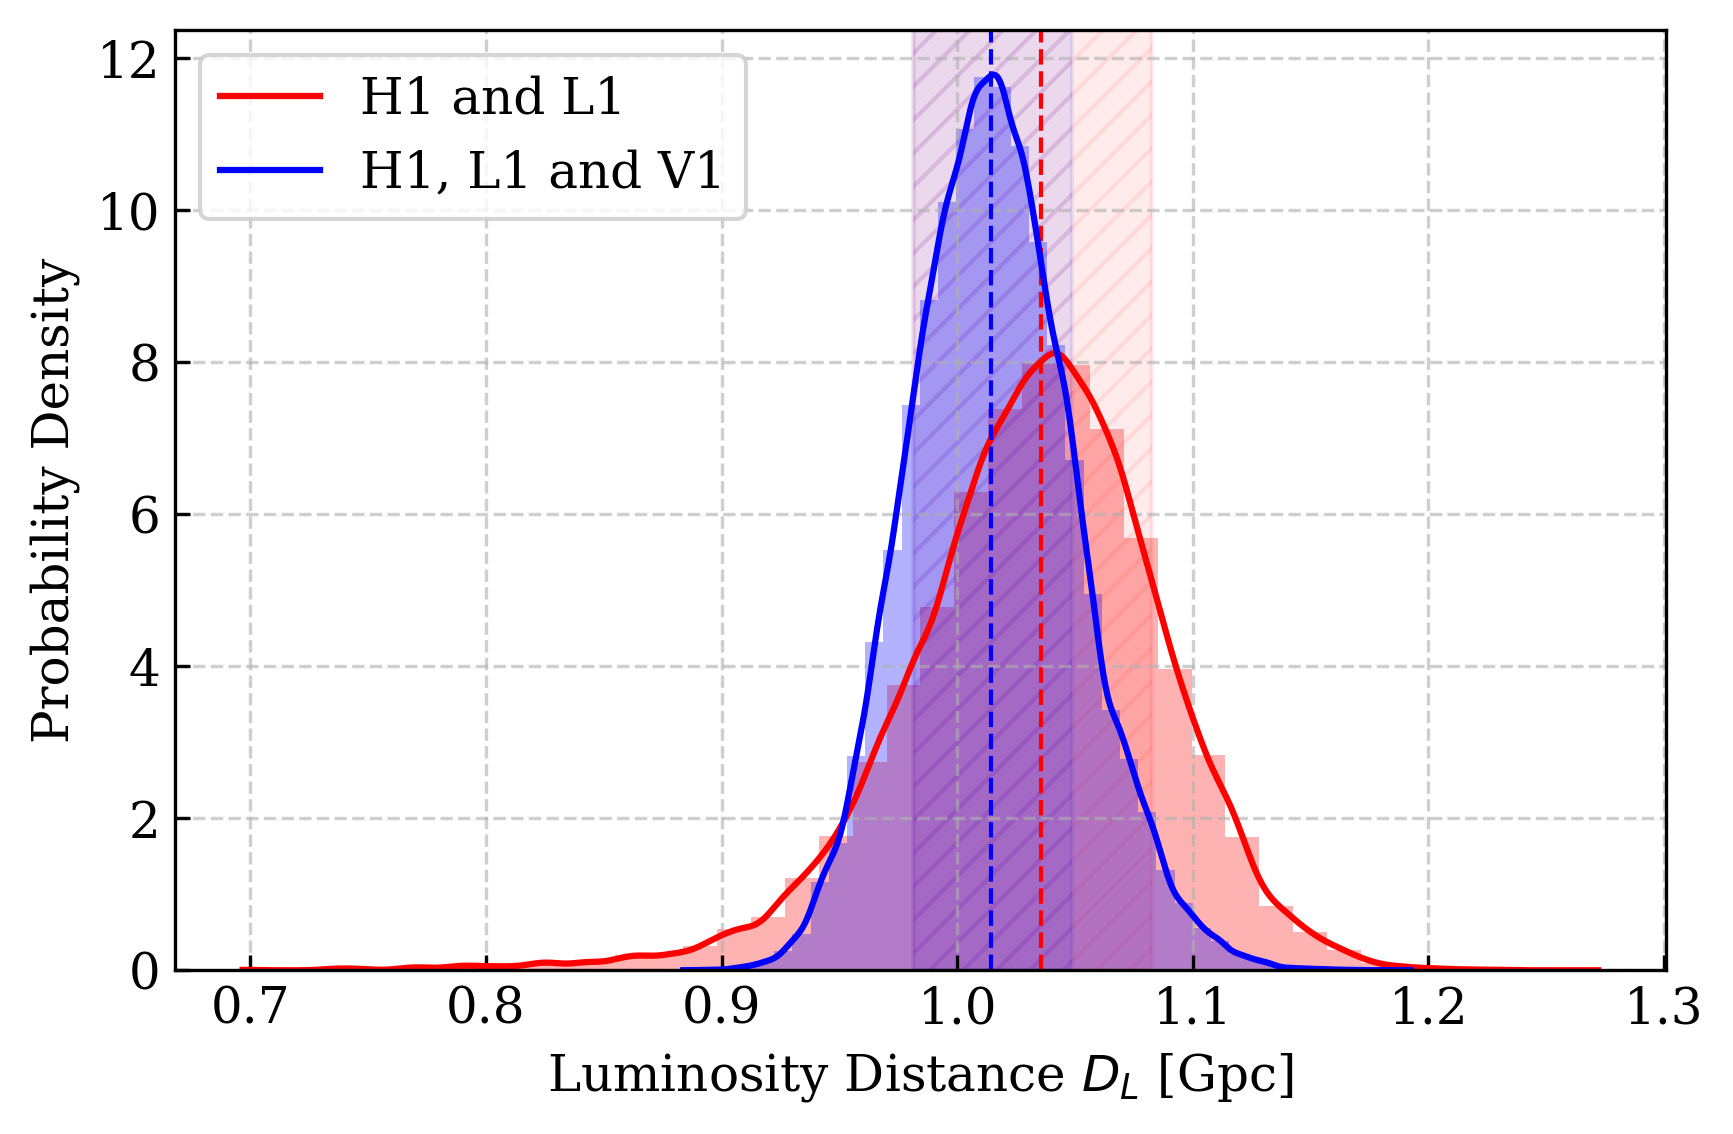

In [22]:
plot_luminosity_distance_marginal(results_H1_L1, results_H1_L1_V1)

## **Additional Convergence Plots**
- Below we simply provide some additional convergence plots for the nested sampling runs to demonstrate the process

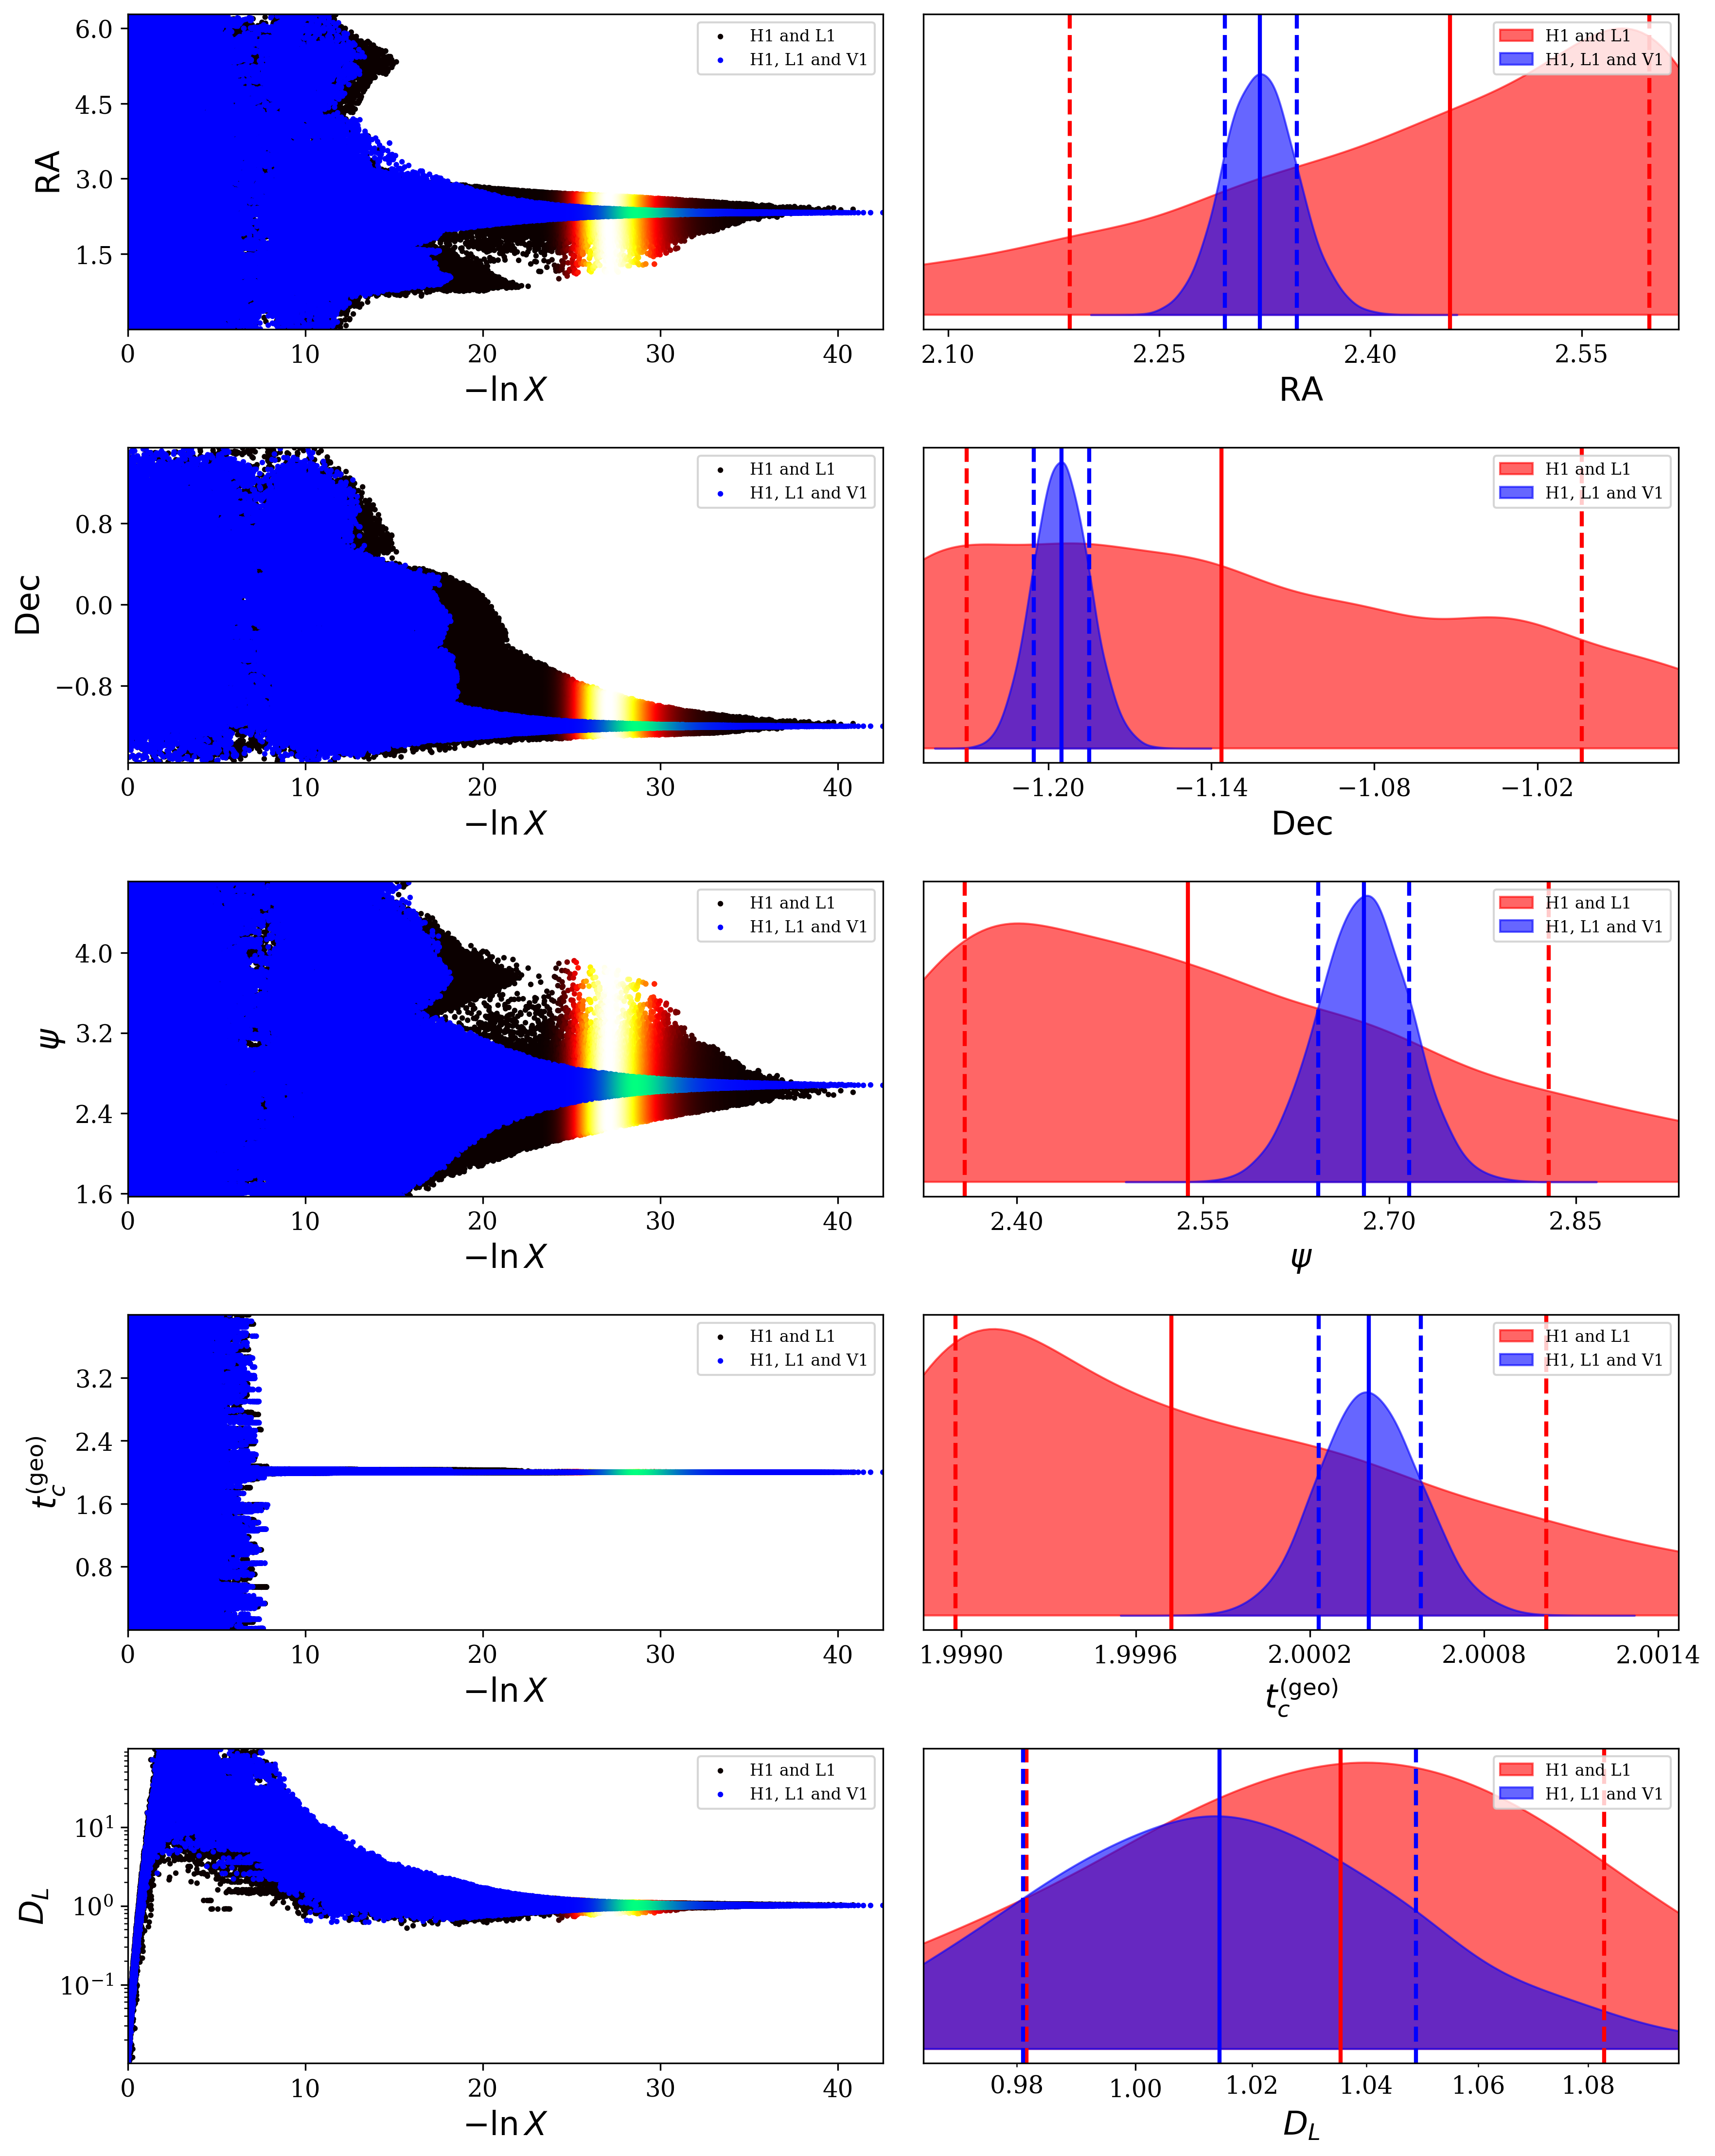

In [23]:
# Plot the convergence of the two results
convergence_dynesty(results_H1_L1, results_H1_L1_V1)
